# PROJECT OVERVIEW
## The Question
Are population biases present in the reports of thunderstorm wind and hail that constitute the offical record of thunderstorm impacts (and are used to create severe-weather climatologies) in the United States?

If there is a populate bias, how significant is it? Does it scale with population density differences across regions, or are there regional difference? How might population biases, if they exist, impact our understanding of severe weather climatology (frequency and severity) in the U.S.?


## The Storm Data
The NOAA Storm Events Database (SED) contains reports of significant weather events, including:
* strong and severe winds (convective, non-convective)
* tornadoes
* hail
* flooding
* tropical cyclones

The record for tornadoes extends back to 1950, with records for hail and thunderstorms extending back to 1955. From 1996 through the present, reports of 48 different hazard types are recorded. See https://www.ncdc.noaa.gov/stormevents/details.jsp?type=eventtype for additional details. This research focuses specifically on hail and thunderstorm wind reports.

Each NOAA SED report includes location information in the form of both the latitude/longitude of the report as well as the county in which the report was made. This research conducts a county-level analysis because the population data used in this analysis are also aggregated by county, enabling an "apples-to-apples" comparison.

The primary metric used in this analysis is the number of storm reports per square mile in each county. This is compared to the population density in each county (number of people per square mile).

## The Population Data
The U.S. Census is conducted every 10 years, counting every resident and collecting data about household composition including the age and sex of household members. These data are aggregated by the U.S. Census Bureau to provide population estimates at the county, state, and national level. This research utilized county-level population data. 

__Urban vs Suburban vs Rural areas:__
Each county was classified as either urban, suburban, or rural. US Census definition of urban areas is complex and has changed over the years (see https://www2.census.gov/geo/pdfs/reference/GARM/Ch12GARM.pdf); however, a recurring general guideline for urban classification is places with a density of at least 1000 people per square mile. After examining histograms of population density in my sample of counties, there appears to be a natural break around a population density of 100 ppl/mi2. So at least provisionally, this is how I'm categorizing my population densities:
   * Urban: population density >= 1000 ppl/mi2
   * Suburban: 100 ppl/mi2 < population density < 1000 ppl/mi2
   * Rural: population density < 100 ppl/mi2

The determination of whether a county is urban or rural is based on the 2020 U.S. Census county population. This is an acknowledged limitation of this research, because population growth between and across counties can be uneven, such that a county that is considered urban in 2020 may have been suburban or even rural in 2000 or 1980. An underlying assumpion - which may prove false - of this research is therefore that population grew evenly _enough_ across counties that the counties with the highest populations in 2020 also had the highest populations in previous years. In other words, I am assuming that the counties I have classified as "urban" based on 2020 census data remained _more urban_ than their neighboring counties that are classified as "rural" throughout the study period. Future work could improve the rigor of this analysis by re-classifying each county decadally based on each U.S. Census (i.e. in 2020, 2010, 2000, 1990, 1980, 1970, 1960, and 1950). 

Because census data provide population snapshots only every 10 years, rather than annually, the decadal population data must be interpolated to an annual frequency for comparison with the SED storm reports data when considering the annual timescale.

## The Study Area
- Five metropolitan areas in the central U.S. that have the following characteristics
    - at least one central county that is urban and densely populated surrounded by counties with progressively lower population density as distance from the central urban county increases (i.e. a radial decrease in population density)
    - geographically homogenous - no significant topographical variability between counties in the same metro area 
    - is prone to both severe wind and severe hail
- In other words, each metro area is small and homogenous enough geographically that it can be assumed to have the same severe weather climatology across all included counties (i.e. over the span of nearly 80 years, one county is unlikely to have experienced substantially more severe storms than a neighborhing county).

__Population Density__
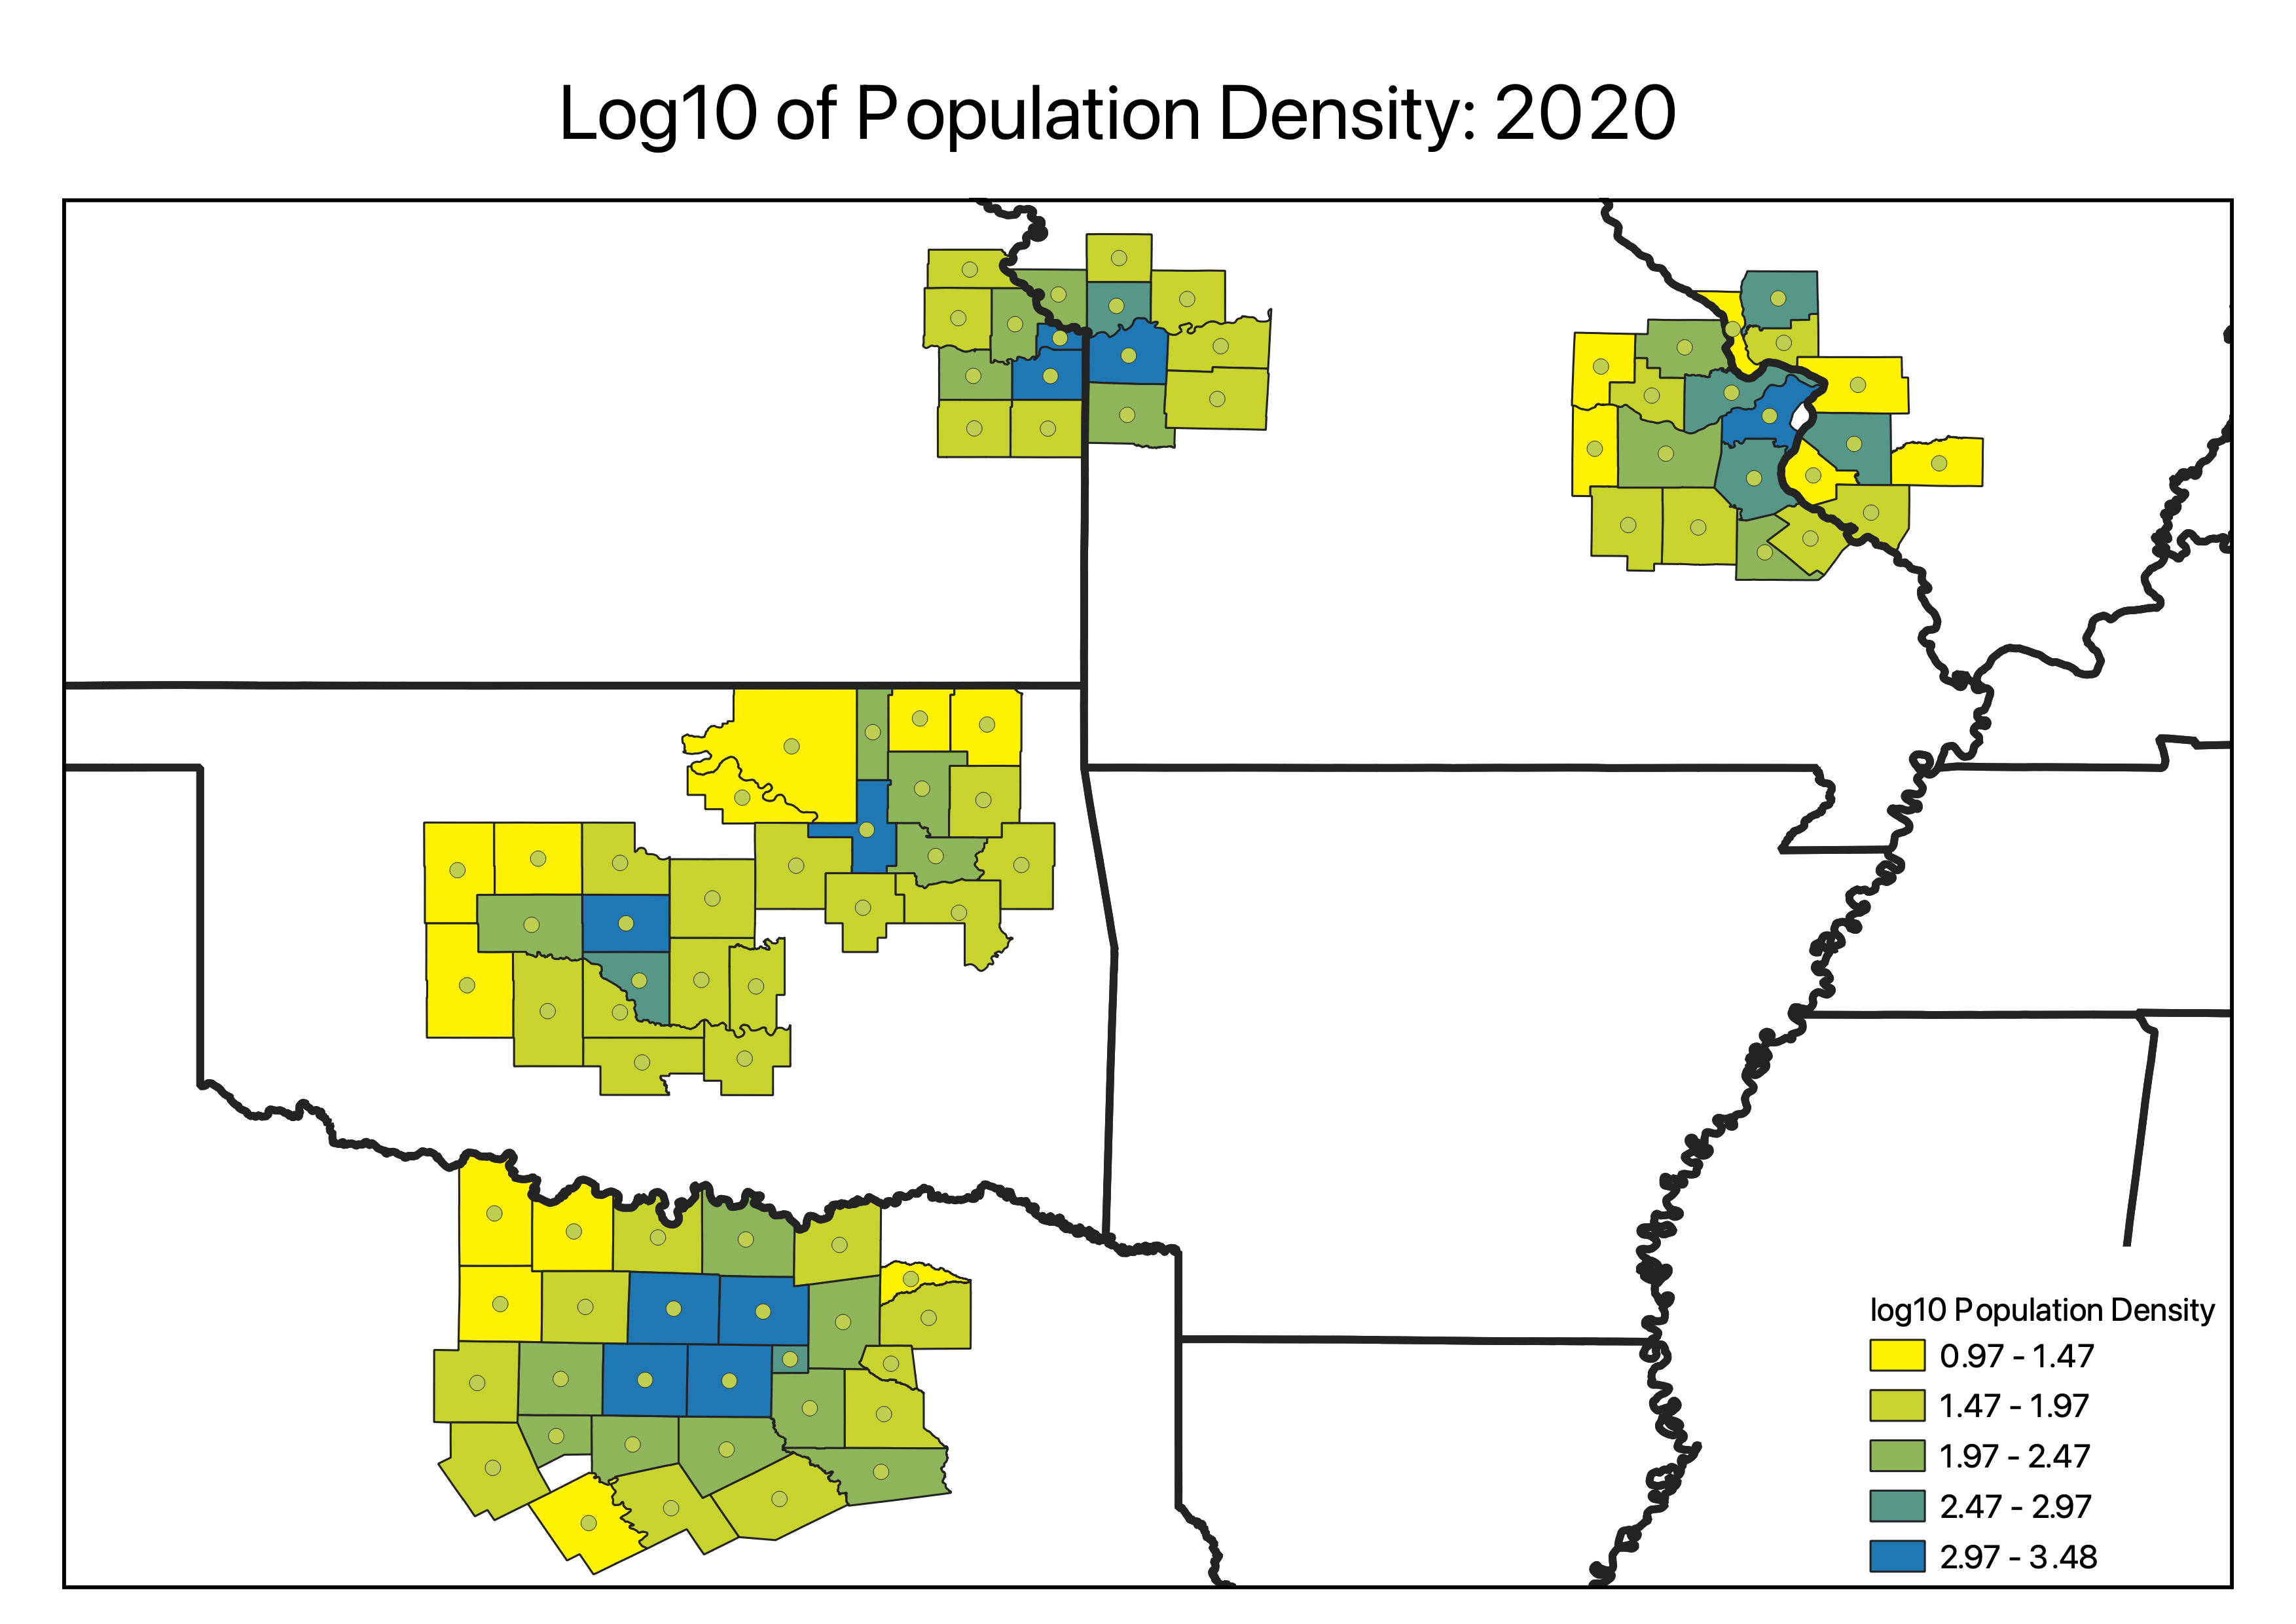

__Severe Weather Climatology__
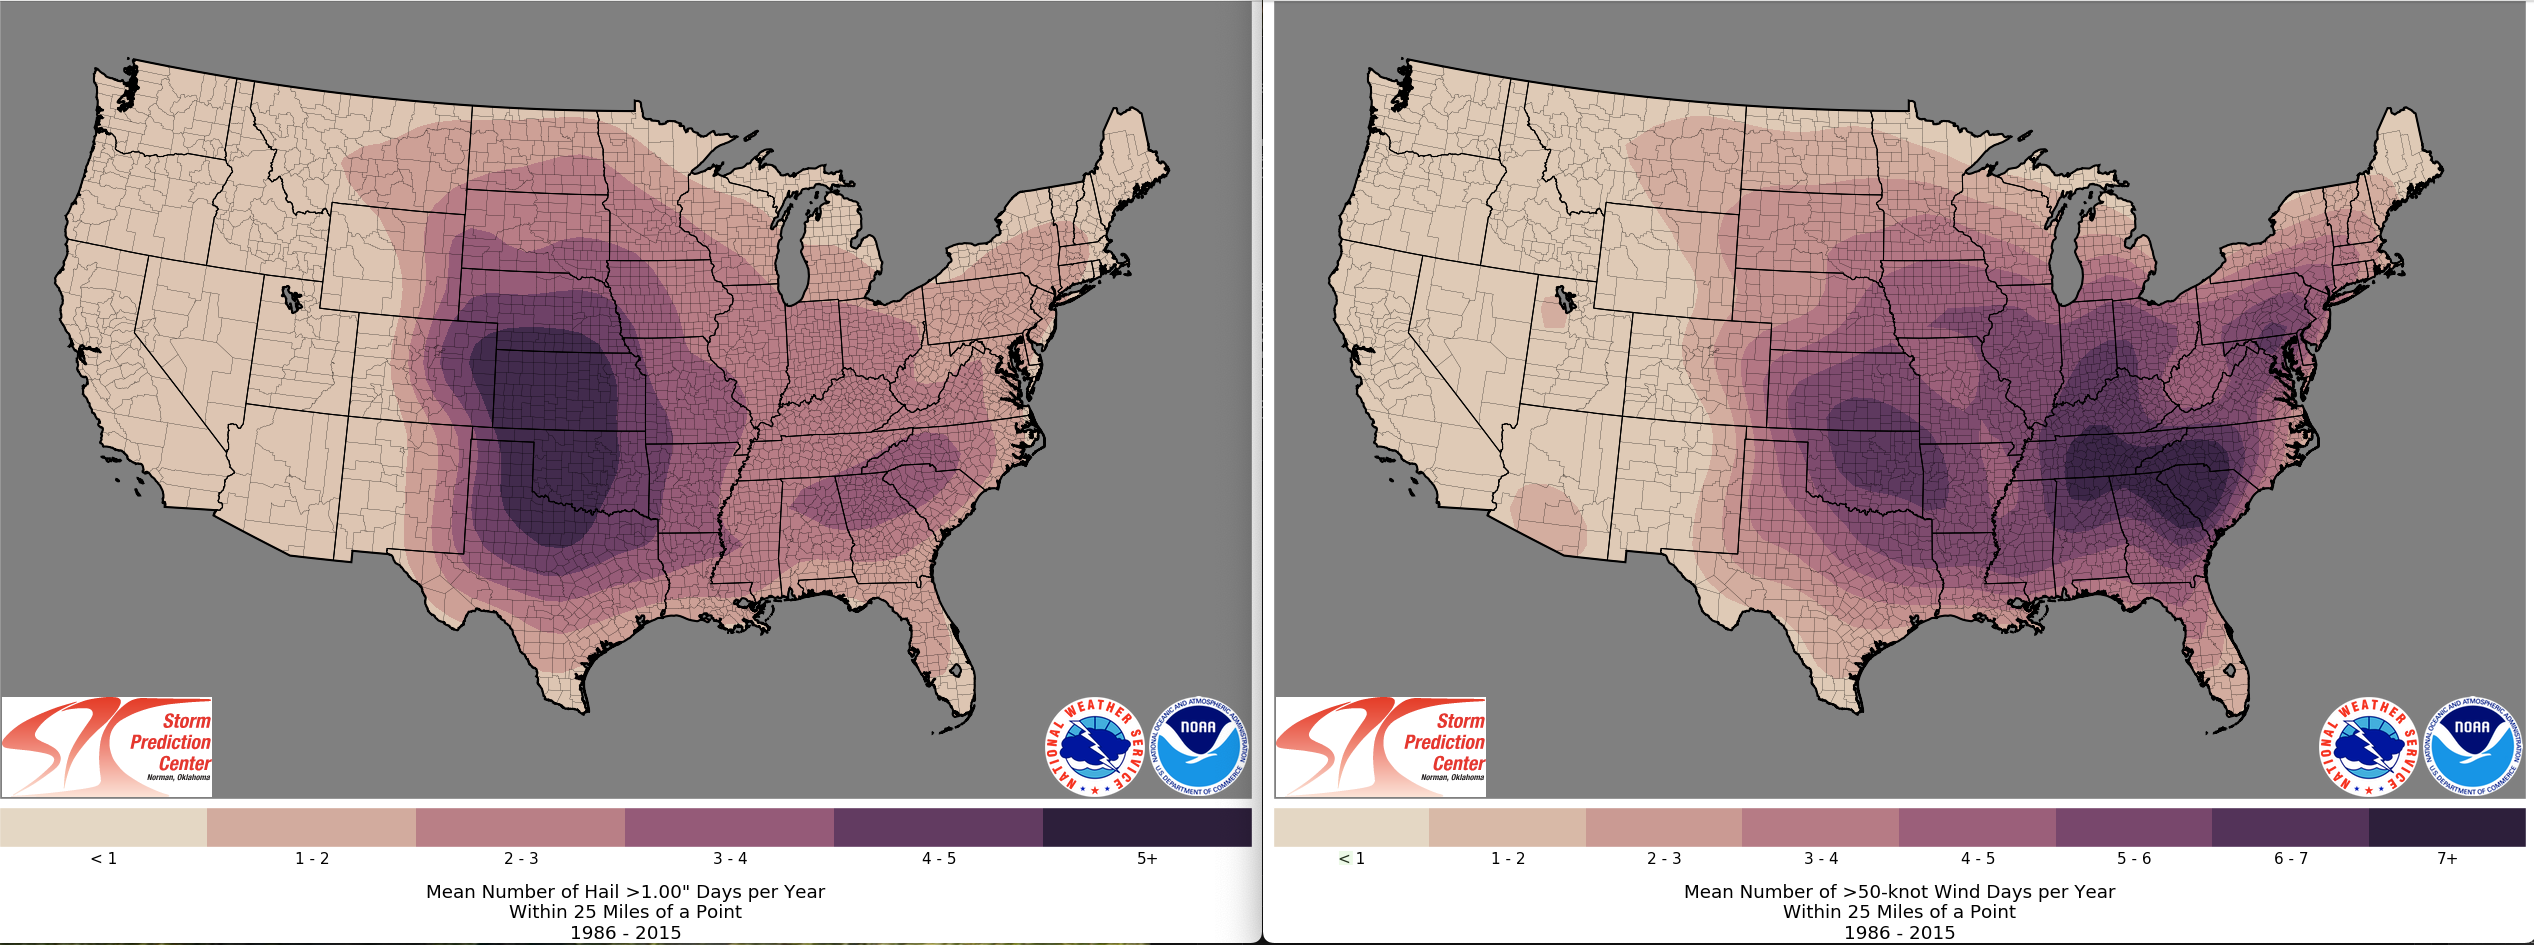

## Project Goals
- Attempt to model the relationship between population density and storm reports density with the goals of:
    1) Predicting the number of storm reports (hail and wind) reported in a given county via ML modeling
    2) Using explainable AI techniques to understand the features that most strongly influence the predicted values of wind and hail reports (is it population density or location?)
    3) Being able to calculate the "missing reports" - the difference between the number of reports that would have been made if a rural county had the same population density as an urban county.
        - This assumes that above a certain population density, all severe weather that occurs gets counted (is observed by someone who reports it to the NWS). For the sake of this initial work, I'm assuming that the "threshold" population density is at or below the population density of the central urban county - in other words, I'm assuming if the outlying counties had the same population density as the central urban county, they would have a similar number of severe wx reports over the nearly 80-year study period.

# BEGIN PROJECT

In [89]:
#IMPORT NECESSARY PACKAGES

import os
from glob import glob

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import chardet 

import csv
import math
import operator
from datetime import datetime
from datetime import tzinfo
from datetime import timedelta
from dateutil import tz
import pytz
from copy import deepcopy 

import seaborn as sb
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error 

from scipy import stats
import statsmodels.api as sm
from statsmodels.discrete.discrete_model import Poisson

pd.set_option("display.max_columns",None)
pd.options.mode.chained_assignment = None  # default='warn'

### Regarding Data Import
I did most of the data processing for this project in ATMS 517 last semester - I analyzed the SED wind and hail reports by county, calculated population density for each county, examined correlations between various metrics of population and storm reports (density, logs of density, absolute values, etc), and ran a Mann-Whitney test to confirm that urban counties have more severe wind and severe hail reports than suburban and rural counties to a statistically significant degree. 

Those data were saved, and I'm importing them here rather than reinterating all that code. For the sake of context, I've also shown some of the big takeaways from that work.

For this short two-week project, I'm building on what I did it ATMS 517 by applying the modeling tools we've explored in this class. 

In [90]:
# Reading in saved files to avoid having to re-run the whole script:

# SET FILEPATHS TO RAW DATA
SED_filepath = '/Users/meganwalker/MDW Docs/Blue Skies Meteorological Services/Operational/Raw Data/NOAA SED reports/'
pop_filepath = '/Users/meganwalker/MDW Docs/Blue Skies Meteorological Services/Operational/Raw Data/Census data/population by county/'
proj_filepath = '/Users/meganwalker/MDW Docs/Academic/Univ Illinois/ATMS 517/project/'
area_filepath = '/Users/meganwalker/MDW Docs/Blue Skies Meteorological Services/Operational/Raw Data/Census data/'

filepath_out = '/Users/meganwalker/MDW Docs/Academic/Univ Illinois/ATMS 517/project/output/'

# READ IN FILES
SED_period_reports_summary = pd.read_csv(filepath_out+'SED_period_reports_summary.csv')
SED_year_reports_summary = pd.read_csv(filepath_out+'SED_year_reports_summary.csv')

merge_keys = pd.read_csv(filepath_out+'merge_keys.csv')
matched_co_pop = pd.read_csv(filepath_out+'matched_co_pop.csv')
pop_data_FIPS = pd.read_csv(filepath_out+'pop_data_FIPS.csv')
county_metro_FIPS = pd.read_csv(proj_filepath + 'county names and FIPS.csv')

# county land area spitting out error with simple read_csv, so specifying encoding
raw_data = open(area_filepath+'county land area with FIPS.csv', 'rb').read()
result = chardet.detect(raw_data)
encode = result['encoding']
co_area = pd.read_csv(area_filepath+'county land area with FIPS.csv', engine='python', encoding = encode)

For the modeling component of this work, I want to use lat and lon as features under the hypothesis that counties located closer to each other have more similar severe weather climatologies. Small differences in severe wx climo between the five metro areas were observed during EDA, so this may be a helpful feature.

I calculated the lat/lon for each county in QGIS - I simply took the centroid for each county from the GIS vector layer, then output that as a .csv file which also contained the county FIPS code (the common feature used for dataframe joins throughout this project).

The county_stats dataframe is the repository of all the features and targets that will be modeled later on. It gets built out feature-by-feature in the following code.

In [91]:
# ADD COUNTY CENTROID LAT/LON (CALCULATED IN QGIS) TO COUNTY_STATS DATAFRAME
county_centroids = pd.read_csv(proj_filepath+'county centroids and FIPS.csv')
centroid_lat_lon = county_centroids[['FIPS','latitude','longitude']]

county_stats = pd.merge(merge_keys,centroid_lat_lon, how='left', left_on='FIPS code', right_on='FIPS')

# ADD POPULATION DATA TO COUNTY_STATS DATAFRAME
pop_density = pd.read_csv(filepath_out+'pop_density.csv', usecols=['FIPS code', 'Pop Density ppl/mi2'])  # population density already calculated and output in early project code
county_stats = county_stats.merge(pop_density, how='left', left_on='FIPS code', right_on='FIPS code')

# DROP EXTRANEOUS COLUMNS
county_stats = county_stats.drop(columns=['Unnamed: 0','FIPS'])

# SET FIPS CODE TO INDEX
county_stats = county_stats.set_index('FIPS code')
county_stats

SED location           Census location Metro Area   latitude  \
FIPS code                                                                      
17013      CALHOUN, ILLINOIS  Calhoun County, Illinois  St. Louis  39.169265   
17061       GREENE, ILLINOIS   Greene County, Missouri  St. Louis  39.356181   
17083       JERSEY, ILLINOIS   Jersey County, Illinois  St. Louis  39.085513   
17119      MADISON, ILLINOIS  Madison County, Missouri  St. Louis  38.829738   
17133       MONROE, ILLINOIS   Monroe County, Missouri  St. Louis  38.278542   
...                      ...                       ...        ...        ...   
48379           RAINS, TEXAS       Rains County, Texas        DFW  32.870350   
48397        ROCKWALL, TEXAS    Rockwall County, Texas        DFW  32.897842   
48439         TARRANT, TEXAS     Tarrant County, Texas        DFW  32.771924   
48467       VAN ZANDT, TEXAS   Van Zandt County, Texas        DFW  32.563711   
48497            WISE, TEXAS        Wise County, Texas        DFW  33.215912   

           longitude  Pop Density ppl/mi2  
FIPS code                                  
17013     -90.667578            17.362082  
17061     -90.390471           551.102470  
17083     -90.356520            58.161843  
17119     -89.904933            17.646031  
17133     -90.177390            22.546009  
...              ...                  ...  
48379     -95.793407            53.052421  
48397     -96.407890           858.099663  
48439     -97.291111          2445.353881  
48467     -95.836500            70.923316  
48497     -97.654465            76.235494  

[91 rows x 6 columns]

In [92]:
# ADD SED HAIL AND WIND REPORTS TO COUNTY_STATS DATAFRAME
county_stats = county_stats.merge(SED_period_reports_summary, how='left', left_on='FIPS code', right_on='FIPS code')
county_stats = county_stats.drop(columns=['index'])
county_stats

FIPS code       SED location           Census location Metro Area  \
0       17013  CALHOUN, ILLINOIS  Calhoun County, Illinois  St. Louis   
1       17061   GREENE, ILLINOIS   Greene County, Missouri  St. Louis   
2       17083   JERSEY, ILLINOIS   Jersey County, Illinois  St. Louis   
3       17119  MADISON, ILLINOIS  Madison County, Missouri  St. Louis   
4       17133   MONROE, ILLINOIS   Monroe County, Missouri  St. Louis   
..        ...                ...                       ...        ...   
86      48379       RAINS, TEXAS       Rains County, Texas        DFW   
87      48397    ROCKWALL, TEXAS    Rockwall County, Texas        DFW   
88      48439     TARRANT, TEXAS     Tarrant County, Texas        DFW   
89      48467   VAN ZANDT, TEXAS   Van Zandt County, Texas        DFW   
90      48497        WISE, TEXAS        Wise County, Texas        DFW   

     latitude  longitude  Pop Density ppl/mi2  Hail Reports  Wind Reports  
0   39.169265 -90.667578            17.362082            32            76  
1   39.356181 -90.390471           551.102470            58            92  
2   39.085513 -90.356520            58.161843            82           112  
3   38.829738 -89.904933            17.646031           271           405  
4   38.278542 -90.177390            22.546009           108           122  
..        ...        ...                  ...           ...           ...  
86  32.870350 -95.793407            53.052421            66            74  
87  32.897842 -96.407890           858.099663            83            86  
88  32.771924 -97.291111          2445.353881          1310           914  
89  32.563711 -95.836500            70.923316           165           200  
90  33.215912 -97.654465            76.235494           446           294  

[91 rows x 9 columns]

In [93]:
# EVALUATE INTERANNUAL VARIABILITY IN SED REPORTS PER COUNTY
SED_reports_interannual_std = SED_year_reports_summary.groupby('FIPS code').std()
SED_reports_interannual_std.rename(columns={'Hail Reports':'Hail Reports std', 'Wind Reports':'Wind Reports std'}, inplace=True)

# ADD INTERANNUAL STD OF SED REPORTS TO COUNTY_STATS DATAFRAME
county_stats = county_stats.merge(SED_reports_interannual_std[['Hail Reports std', 'Wind Reports std']], how='left', left_on='FIPS code', right_on='FIPS code')
county_stats


FIPS code       SED location           Census location Metro Area  \
0       17013  CALHOUN, ILLINOIS  Calhoun County, Illinois  St. Louis   
1       17061   GREENE, ILLINOIS   Greene County, Missouri  St. Louis   
2       17083   JERSEY, ILLINOIS   Jersey County, Illinois  St. Louis   
3       17119  MADISON, ILLINOIS  Madison County, Missouri  St. Louis   
4       17133   MONROE, ILLINOIS   Monroe County, Missouri  St. Louis   
..        ...                ...                       ...        ...   
86      48379       RAINS, TEXAS       Rains County, Texas        DFW   
87      48397    ROCKWALL, TEXAS    Rockwall County, Texas        DFW   
88      48439     TARRANT, TEXAS     Tarrant County, Texas        DFW   
89      48467   VAN ZANDT, TEXAS   Van Zandt County, Texas        DFW   
90      48497        WISE, TEXAS        Wise County, Texas        DFW   

     latitude  longitude  Pop Density ppl/mi2  Hail Reports  Wind Reports  \
0   39.169265 -90.667578            17.362082            32            76   
1   39.356181 -90.390471           551.102470            58            92   
2   39.085513 -90.356520            58.161843            82           112   
3   38.829738 -89.904933            17.646031           271           405   
4   38.278542 -90.177390            22.546009           108           122   
..        ...        ...                  ...           ...           ...   
86  32.870350 -95.793407            53.052421            66            74   
87  32.897842 -96.407890           858.099663            83            86   
88  32.771924 -97.291111          2445.353881          1310           914   
89  32.563711 -95.836500            70.923316           165           200   
90  33.215912 -97.654465            76.235494           446           294   

    Hail Reports std  Wind Reports std  
0           0.879488          1.576483  
1           1.623839          1.583821  
2           1.910849          1.852534  
3           6.102794          6.097975  
4           2.630290          2.224278  
..               ...               ...  
86          1.512132          1.640835  
87          2.094111          1.729299  
88         22.308861         10.982048  
89          3.239412          3.580485  
90          6.496758          5.179670  

[91 rows x 11 columns]

In [94]:
# ADD LAND AREA TO COUNTY_STATS DATAFRAME
county_stats = county_stats.merge(co_area[['FIPS code','Area - Land mi2']], how='left', left_on='FIPS code', right_on='FIPS code')
county_stats 

FIPS code       SED location           Census location Metro Area  \
0       17013  CALHOUN, ILLINOIS  Calhoun County, Illinois  St. Louis   
1       17061   GREENE, ILLINOIS   Greene County, Missouri  St. Louis   
2       17083   JERSEY, ILLINOIS   Jersey County, Illinois  St. Louis   
3       17119  MADISON, ILLINOIS  Madison County, Missouri  St. Louis   
4       17133   MONROE, ILLINOIS   Monroe County, Missouri  St. Louis   
..        ...                ...                       ...        ...   
86      48379       RAINS, TEXAS       Rains County, Texas        DFW   
87      48397    ROCKWALL, TEXAS    Rockwall County, Texas        DFW   
88      48439     TARRANT, TEXAS     Tarrant County, Texas        DFW   
89      48467   VAN ZANDT, TEXAS   Van Zandt County, Texas        DFW   
90      48497        WISE, TEXAS        Wise County, Texas        DFW   

     latitude  longitude  Pop Density ppl/mi2  Hail Reports  Wind Reports  \
0   39.169265 -90.667578            17.362082            32            76   
1   39.356181 -90.390471           551.102470            58            92   
2   39.085513 -90.356520            58.161843            82           112   
3   38.829738 -89.904933            17.646031           271           405   
4   38.278542 -90.177390            22.546009           108           122   
..        ...        ...                  ...           ...           ...   
86  32.870350 -95.793407            53.052421            66            74   
87  32.897842 -96.407890           858.099663            83            86   
88  32.771924 -97.291111          2445.353881          1310           914   
89  32.563711 -95.836500            70.923316           165           200   
90  33.215912 -97.654465            76.235494           446           294   

    Hail Reports std  Wind Reports std Area - Land mi2  
0           0.879488          1.576483         253.829  
1           1.623839          1.583821         543.144  
2           1.910849          1.852534         369.555  
3           6.102794          6.097975         715.515  
4           2.630290          2.224278         385.301  
..               ...               ...             ...  
86          1.512132          1.640835         229.490  
87          2.094111          1.729299         127.209  
88         22.308861         10.982048         865.249  
89          3.239412          3.580485         842.572  
90          6.496758          5.179670         904.395  

[91 rows x 12 columns]

In [95]:
type(county_stats['Area - Land mi2'].iloc[0])

str

In [96]:
# LAND AREA GOT IMPORTED AS A STRING, NEED TO CLEAN AND CONVERT TO NUMERIC
county_stats['Area - Land mi2'] = (
    county_stats['Area - Land mi2']              # ensure string operations are safe
    .astype(str)
    .str.replace(',', '', regex=False)           # remove thousands separators
    .str.strip()                                  # trim whitespace
    .replace({'': np.nan})                        # empty strings -> NaN
    .pipe(pd.to_numeric, errors='coerce')         # convert to numeric, invalid -> NaN
)
type(county_stats['Area - Land mi2'].iloc[0])         # ensure string operations are safe

numpy.float64

In [97]:
# CALCULATE REPORTS PER SQ MI
county_stats['Total Hail Reports per mi2'] = county_stats['Hail Reports'] / county_stats['Area - Land mi2']
county_stats['Total Wind Reports per mi2'] = county_stats['Wind Reports'] / county_stats['Area - Land mi2']
county_stats

FIPS code       SED location           Census location Metro Area  \
0       17013  CALHOUN, ILLINOIS  Calhoun County, Illinois  St. Louis   
1       17061   GREENE, ILLINOIS   Greene County, Missouri  St. Louis   
2       17083   JERSEY, ILLINOIS   Jersey County, Illinois  St. Louis   
3       17119  MADISON, ILLINOIS  Madison County, Missouri  St. Louis   
4       17133   MONROE, ILLINOIS   Monroe County, Missouri  St. Louis   
..        ...                ...                       ...        ...   
86      48379       RAINS, TEXAS       Rains County, Texas        DFW   
87      48397    ROCKWALL, TEXAS    Rockwall County, Texas        DFW   
88      48439     TARRANT, TEXAS     Tarrant County, Texas        DFW   
89      48467   VAN ZANDT, TEXAS   Van Zandt County, Texas        DFW   
90      48497        WISE, TEXAS        Wise County, Texas        DFW   

     latitude  longitude  Pop Density ppl/mi2  Hail Reports  Wind Reports  \
0   39.169265 -90.667578            17.362082            32            76   
1   39.356181 -90.390471           551.102470            58            92   
2   39.085513 -90.356520            58.161843            82           112   
3   38.829738 -89.904933            17.646031           271           405   
4   38.278542 -90.177390            22.546009           108           122   
..        ...        ...                  ...           ...           ...   
86  32.870350 -95.793407            53.052421            66            74   
87  32.897842 -96.407890           858.099663            83            86   
88  32.771924 -97.291111          2445.353881          1310           914   
89  32.563711 -95.836500            70.923316           165           200   
90  33.215912 -97.654465            76.235494           446           294   

    Hail Reports std  Wind Reports std  Area - Land mi2  \
0           0.879488          1.576483          253.829   
1           1.623839          1.583821          543.144   
2           1.910849          1.852534          369.555   
3           6.102794          6.097975          715.515   
4           2.630290          2.224278          385.301   
..               ...               ...              ...   
86          1.512132          1.640835          229.490   
87          2.094111          1.729299          127.209   
88         22.308861         10.982048          865.249   
89          3.239412          3.580485          842.572   
90          6.496758          5.179670          904.395   

    Total Hail Reports per mi2  Total Wind Reports per mi2  
0                     0.126069                    0.299414  
1                     0.106786                    0.169384  
2                     0.221888                    0.303067  
3                     0.378748                    0.566026  
4                     0.280300                    0.316636  
..                         ...                         ...  
86                    0.287594                    0.322454  
87                    0.652470                    0.676053  
88                    1.514015                    1.056343  
89                    0.195829                    0.237368  
90                    0.493147                    0.325079  

[91 rows x 14 columns]

In [ ]:
# EVALUATE INTERANNUAL VARIABILITY IN SED REPORTS DENSITY PER COUNTY
# using SED_year_reports_summary, which contains the total number of wind reports and hail reports in each county for each year

# CALCULATE STD OF REPORTS PER SQ MI
SED_year_reports_density = SED_year_reports_summary.copy(deep=True)
SED_year_reports_density = SED_year_reports_density.merge(co_area[['FIPS code','Area - Land mi2']], how='left', left_on='FIPS code', right_on='FIPS code') 
SED_year_reports_density 

# LAND AREA GOT IMPORTED AS A STRING, NEED TO CLEAN AND CONVERT TO NUMERIC
SED_year_reports_density['Area - Land mi2'] = (
    SED_year_reports_density['Area - Land mi2']  # clean up all the excel-formatted nonsense
    .astype(str)
    .str.replace(',', '', regex=False)           # remove thousands separators
    .str.strip()                                  # trim whitespace
    .replace({'': np.nan})                        # empty strings -> NaN
    .pipe(pd.to_numeric, errors='coerce')         # convert to numeric, invalid -> NaN
)

SED_year_reports_density['Hail Reports per mi2'] = SED_year_reports_density['Hail Reports'] / SED_year_reports_density['Area - Land mi2']
SED_year_reports_density['Wind Reports per mi2'] = SED_year_reports_density['Wind Reports'] / SED_year_reports_density['Area - Land mi2']
SED_year_reports_density_std = SED_year_reports_density.groupby('FIPS code').std()
SED_year_reports_density_std.drop(columns=['index', 'Year', 'Area - Land mi2'], inplace=True)
SED_year_reports_density_std.rename(columns={'Hail Reports per mi2':'Hail Reports Density std', 'Wind Reports per mi2':'Wind Reports Density std'}, inplace=True)
SED_year_reports_density_std

Hail Reports  Wind Reports  Hail Reports Density std  \
FIPS code                                                         
17013          0.879488      1.576483                  0.003465   
17061          1.623839      1.583821                  0.002990   
17083          1.910849      1.852534                  0.005171   
17119          6.102794      6.097975                  0.008529   
17133          2.630290      2.224278                  0.006827   
...                 ...           ...                       ...   
48379          1.512132      1.640835                  0.006589   
48397          2.094111      1.729299                  0.016462   
48439         22.308861     10.982048                  0.025783   
48467          3.239412      3.580485                  0.003845   
48497          6.496758      5.179670                  0.007184   

           Wind Reports Density std  
FIPS code                            
17013                      0.006211  
17061                      0.002916  
17083                      0.005013  
17119                      0.008522  
17133                      0.005773  
...                             ...  
48379                      0.007150  
48397                      0.013594  
48439                      0.012692  
48467                      0.004249  
48497                      0.005727  

[91 rows x 4 columns]

In [99]:
# MERGE STD OF REPORTS PER SQ MI INTO COUNTY_STATS DATAFRAME
county_stats = county_stats.merge(SED_year_reports_density_std[['Hail Reports Density std', 'Wind Reports Density std']], how='left', left_on='FIPS code', right_on='FIPS code')
county_stats

FIPS code       SED location           Census location Metro Area  \
0       17013  CALHOUN, ILLINOIS  Calhoun County, Illinois  St. Louis   
1       17061   GREENE, ILLINOIS   Greene County, Missouri  St. Louis   
2       17083   JERSEY, ILLINOIS   Jersey County, Illinois  St. Louis   
3       17119  MADISON, ILLINOIS  Madison County, Missouri  St. Louis   
4       17133   MONROE, ILLINOIS   Monroe County, Missouri  St. Louis   
..        ...                ...                       ...        ...   
86      48379       RAINS, TEXAS       Rains County, Texas        DFW   
87      48397    ROCKWALL, TEXAS    Rockwall County, Texas        DFW   
88      48439     TARRANT, TEXAS     Tarrant County, Texas        DFW   
89      48467   VAN ZANDT, TEXAS   Van Zandt County, Texas        DFW   
90      48497        WISE, TEXAS        Wise County, Texas        DFW   

     latitude  longitude  Pop Density ppl/mi2  Hail Reports  Wind Reports  \
0   39.169265 -90.667578            17.362082            32            76   
1   39.356181 -90.390471           551.102470            58            92   
2   39.085513 -90.356520            58.161843            82           112   
3   38.829738 -89.904933            17.646031           271           405   
4   38.278542 -90.177390            22.546009           108           122   
..        ...        ...                  ...           ...           ...   
86  32.870350 -95.793407            53.052421            66            74   
87  32.897842 -96.407890           858.099663            83            86   
88  32.771924 -97.291111          2445.353881          1310           914   
89  32.563711 -95.836500            70.923316           165           200   
90  33.215912 -97.654465            76.235494           446           294   

    Hail Reports std  Wind Reports std  Area - Land mi2  \
0           0.879488          1.576483          253.829   
1           1.623839          1.583821          543.144   
2           1.910849          1.852534          369.555   
3           6.102794          6.097975          715.515   
4           2.630290          2.224278          385.301   
..               ...               ...              ...   
86          1.512132          1.640835          229.490   
87          2.094111          1.729299          127.209   
88         22.308861         10.982048          865.249   
89          3.239412          3.580485          842.572   
90          6.496758          5.179670          904.395   

    Total Hail Reports per mi2  Total Wind Reports per mi2  \
0                     0.126069                    0.299414   
1                     0.106786                    0.169384   
2                     0.221888                    0.303067   
3                     0.378748                    0.566026   
4                     0.280300                    0.316636   
..                         ...                         ...   
86                    0.287594                    0.322454   
87                    0.652470                    0.676053   
88                    1.514015                    1.056343   
89                    0.195829                    0.237368   
90                    0.493147                    0.325079   

    Hail Reports Density std  Wind Reports Density std  
0                   0.003465                  0.006211  
1                   0.002990                  0.002916  
2                   0.005171                  0.005013  
3                   0.008529                  0.008522  
4                   0.006827                  0.005773  
..                       ...                       ...  
86                  0.006589                  0.007150  
87                  0.016462                  0.013594  
88                  0.025783                  0.012692  
89                  0.003845                  0.004249  
90                  0.007184                  0.005727  

[91 rows x 16 columns]

In [100]:
# CLEAN UP NAMING OF COLUMNS
county_stats.rename(columns={
    'Hail Reports':'Total Hail Reports',
    'Wind Reports':'Total Wind Reports',
    'Total Hail Reports per mi2':'Hail Reports Density rep/mi2',
    'Total Wind Reports per mi2':'Wind Reports Density rep/mi2',
}, inplace=True)

county_stats 

FIPS code       SED location           Census location Metro Area  \
0       17013  CALHOUN, ILLINOIS  Calhoun County, Illinois  St. Louis   
1       17061   GREENE, ILLINOIS   Greene County, Missouri  St. Louis   
2       17083   JERSEY, ILLINOIS   Jersey County, Illinois  St. Louis   
3       17119  MADISON, ILLINOIS  Madison County, Missouri  St. Louis   
4       17133   MONROE, ILLINOIS   Monroe County, Missouri  St. Louis   
..        ...                ...                       ...        ...   
86      48379       RAINS, TEXAS       Rains County, Texas        DFW   
87      48397    ROCKWALL, TEXAS    Rockwall County, Texas        DFW   
88      48439     TARRANT, TEXAS     Tarrant County, Texas        DFW   
89      48467   VAN ZANDT, TEXAS   Van Zandt County, Texas        DFW   
90      48497        WISE, TEXAS        Wise County, Texas        DFW   

     latitude  longitude  Pop Density ppl/mi2  Total Hail Reports  \
0   39.169265 -90.667578            17.362082                  32   
1   39.356181 -90.390471           551.102470                  58   
2   39.085513 -90.356520            58.161843                  82   
3   38.829738 -89.904933            17.646031                 271   
4   38.278542 -90.177390            22.546009                 108   
..        ...        ...                  ...                 ...   
86  32.870350 -95.793407            53.052421                  66   
87  32.897842 -96.407890           858.099663                  83   
88  32.771924 -97.291111          2445.353881                1310   
89  32.563711 -95.836500            70.923316                 165   
90  33.215912 -97.654465            76.235494                 446   

    Total Wind Reports  Hail Reports std  Wind Reports std  Area - Land mi2  \
0                   76          0.879488          1.576483          253.829   
1                   92          1.623839          1.583821          543.144   
2                  112          1.910849          1.852534          369.555   
3                  405          6.102794          6.097975          715.515   
4                  122          2.630290          2.224278          385.301   
..                 ...               ...               ...              ...   
86                  74          1.512132          1.640835          229.490   
87                  86          2.094111          1.729299          127.209   
88                 914         22.308861         10.982048          865.249   
89                 200          3.239412          3.580485          842.572   
90                 294          6.496758          5.179670          904.395   

    Hail Reports Density rep/mi2  Wind Reports Density rep/mi2  \
0                       0.126069                      0.299414   
1                       0.106786                      0.169384   
2                       0.221888                      0.303067   
3                       0.378748                      0.566026   
4                       0.280300                      0.316636   
..                           ...                           ...   
86                      0.287594                      0.322454   
87                      0.652470                      0.676053   
88                      1.514015                      1.056343   
89                      0.195829                      0.237368   
90                      0.493147                      0.325079   

    Hail Reports Density std  Wind Reports Density std  
0                   0.003465                  0.006211  
1                   0.002990                  0.002916  
2                   0.005171                  0.005013  
3                   0.008529                  0.008522  
4                   0.006827                  0.005773  
..                       ...                       ...  
86                  0.006589                  0.007150  
87                  0.016462                  0.013594  
88                  0.025783               

In [101]:
# ADD LOG10 POPULATION DENSITY COLUMN
county_stats['Log10 Pop Density ppl/mi2'] = np.log10(county_stats['Pop Density ppl/mi2'])
county_stats

FIPS code       SED location           Census location Metro Area  \
0       17013  CALHOUN, ILLINOIS  Calhoun County, Illinois  St. Louis   
1       17061   GREENE, ILLINOIS   Greene County, Missouri  St. Louis   
2       17083   JERSEY, ILLINOIS   Jersey County, Illinois  St. Louis   
3       17119  MADISON, ILLINOIS  Madison County, Missouri  St. Louis   
4       17133   MONROE, ILLINOIS   Monroe County, Missouri  St. Louis   
..        ...                ...                       ...        ...   
86      48379       RAINS, TEXAS       Rains County, Texas        DFW   
87      48397    ROCKWALL, TEXAS    Rockwall County, Texas        DFW   
88      48439     TARRANT, TEXAS     Tarrant County, Texas        DFW   
89      48467   VAN ZANDT, TEXAS   Van Zandt County, Texas        DFW   
90      48497        WISE, TEXAS        Wise County, Texas        DFW   

     latitude  longitude  Pop Density ppl/mi2  Total Hail Reports  \
0   39.169265 -90.667578            17.362082                  32   
1   39.356181 -90.390471           551.102470                  58   
2   39.085513 -90.356520            58.161843                  82   
3   38.829738 -89.904933            17.646031                 271   
4   38.278542 -90.177390            22.546009                 108   
..        ...        ...                  ...                 ...   
86  32.870350 -95.793407            53.052421                  66   
87  32.897842 -96.407890           858.099663                  83   
88  32.771924 -97.291111          2445.353881                1310   
89  32.563711 -95.836500            70.923316                 165   
90  33.215912 -97.654465            76.235494                 446   

    Total Wind Reports  Hail Reports std  Wind Reports std  Area - Land mi2  \
0                   76          0.879488          1.576483          253.829   
1                   92          1.623839          1.583821          543.144   
2                  112          1.910849          1.852534          369.555   
3                  405          6.102794          6.097975          715.515   
4                  122          2.630290          2.224278          385.301   
..                 ...               ...               ...              ...   
86                  74          1.512132          1.640835          229.490   
87                  86          2.094111          1.729299          127.209   
88                 914         22.308861         10.982048          865.249   
89                 200          3.239412          3.580485          842.572   
90                 294          6.496758          5.179670          904.395   

    Hail Reports Density rep/mi2  Wind Reports Density rep/mi2  \
0                       0.126069                      0.299414   
1                       0.106786                      0.169384   
2                       0.221888                      0.303067   
3                       0.378748                      0.566026   
4                       0.280300                      0.316636   
..                           ...                           ...   
86                      0.287594                      0.322454   
87                      0.652470                      0.676053   
88                      1.514015                      1.056343   
89                      0.195829                      0.237368   
90                      0.493147                      0.325079   

    Hail Reports Density std  Wind Reports Density std  \
0                   0.003465                  0.006211   
1                   0.002990                  0.002916   
2                   0.005171                  0.005013   
3                   0.008529                  0.008522   
4                   0.006827                  0.005773   
..                       ...                       ...   
86                  0.006589                  0.007150   
87                  0.016462                  0.013594   
88                  0.025783      

In [102]:
# SAVE FINAL COUNTY_STATS DATAFRAME
county_stats.to_csv(filepath_out+'county_stats.csv')

## EXPLORATORY PLOTTING
Providing the context for the final modeling piece

In [ ]:
# Setting up variables for scatter plots

period_summary_sub_metro_raw = county_stats[['Metro Area','Hail Reports Density rep/mi2','Wind Reports Density rep/mi2','Pop Density ppl/mi2','Log10 Pop Density ppl/mi2']]
period_summary_sub_metro_raw = period_summary_sub_metro_raw.groupby('Metro Area')

# Loop through all groups and create the pairplot
cities = list(period_summary_sub_metro_raw.groups.keys())
print(cities)


['DFW', 'Kansas City', 'OKC', 'St. Louis', 'Tulsa ']


### Wind Reports Density vs Hail Reports Density

DFW
Kansas City
OKC
St. Louis
Tulsa 


Text(0.5, 1.0, 'Wind Reports Density vs Hail Reports Density: 1955 - 2024')

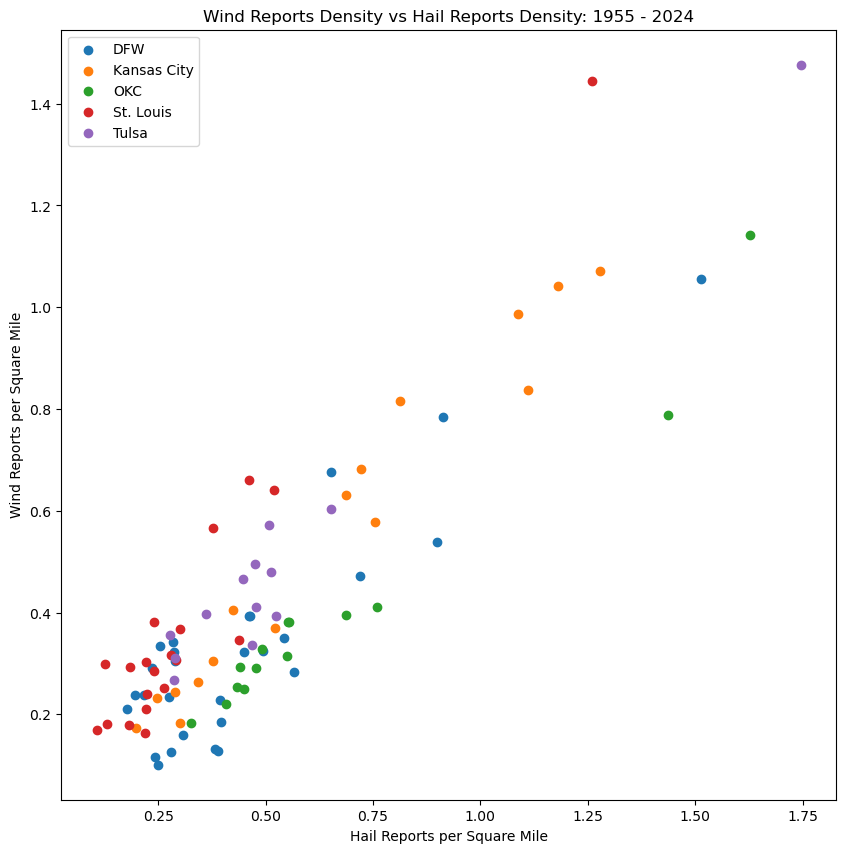

In [104]:
# Wind Reports Density vs Hail Reports Density
# Color coded by metro area

fig,ax = plt.subplots(figsize=(10,10))

for city in cities:
    print(city)
    ax.scatter(x=period_summary_sub_metro_raw.get_group(city)['Hail Reports Density rep/mi2'], y=period_summary_sub_metro_raw.get_group(city)['Wind Reports Density rep/mi2'], label = city)    

ax.legend()
ax.set_xlabel('Hail Reports per Square Mile')
ax.set_ylabel('Wind Reports per Square Mile')
ax.set_title('Wind Reports Density vs Hail Reports Density: 1955 - 2024')

### Wind Reports Density vs Log10 of Population Density and Same for Hail
Population density is not normally distributed - there are far more low population density counties in this study than there are high population density counties. EDA showed that taking Log10 of Population Density provided a more normal distribution and also aided in plotting visualizations.

DFW
Kansas City
OKC
St. Louis
Tulsa 


Text(0.5, 1.0, 'Hail Reports Density vs Log10 of Population Density: 1955 - 2024')

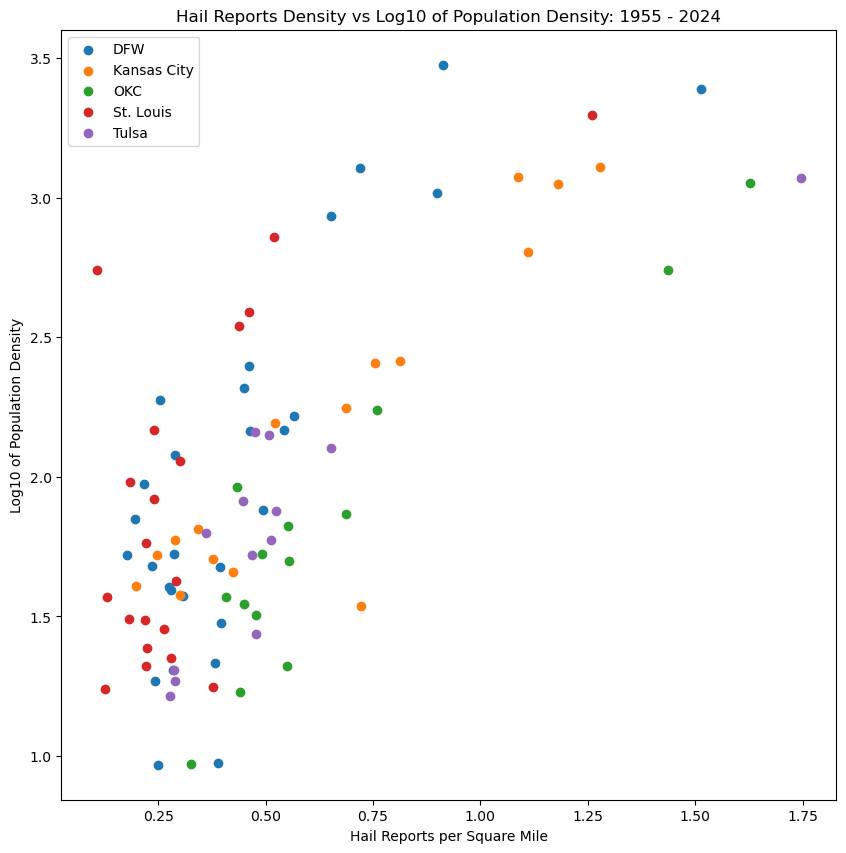

In [105]:
# Wind Reports Density vs Log10 of Population Density
# Color coded by metro area

fig,ax = plt.subplots(figsize=(10,10))

for city in cities:
    print(city)
    ax.scatter(x=period_summary_sub_metro_raw.get_group(city)['Hail Reports Density rep/mi2'], y=period_summary_sub_metro_raw.get_group(city)['Log10 Pop Density ppl/mi2'], label = city)    

ax.legend()
ax.set_xlabel('Hail Reports per Square Mile')
ax.set_ylabel('Log10 of Population Density')
ax.set_title('Hail Reports Density vs Log10 of Population Density: 1955 - 2024')

DFW
Kansas City
OKC
St. Louis
Tulsa 


Text(0.5, 1.0, 'Wind Reports Density vs Log10 of Population Density: 1955 - 2024')

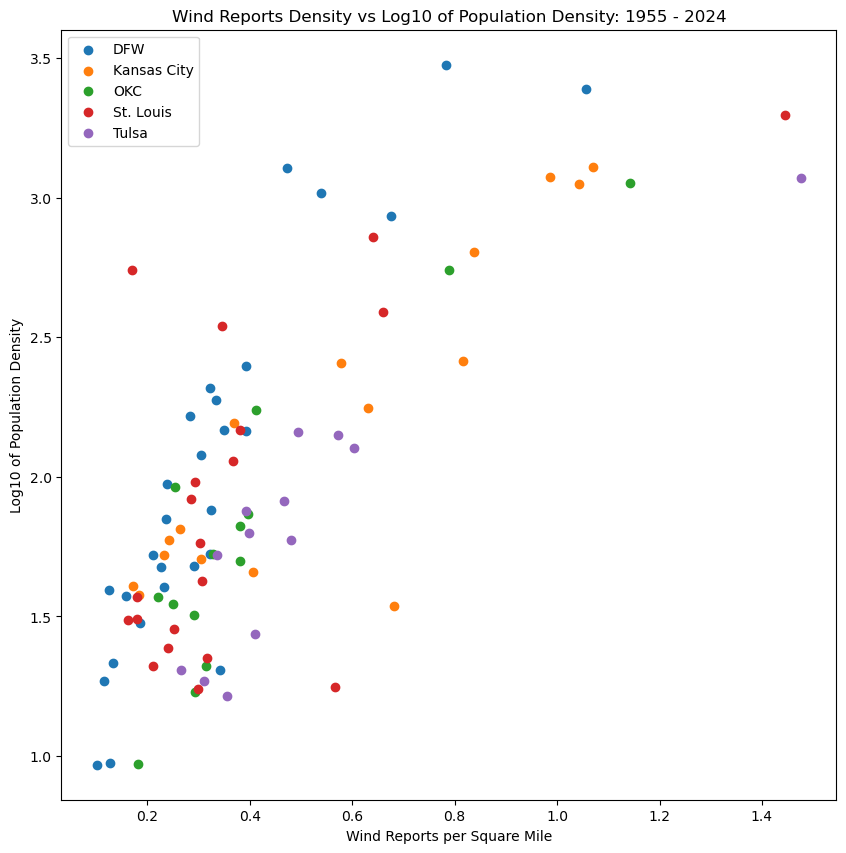

In [106]:
# Wind Reports Density vs Log10 of Population Density
# Color coded by metro area

fig,ax = plt.subplots(figsize=(10,10))

for city in cities:
    print(city)
    ax.scatter(x=period_summary_sub_metro_raw.get_group(city)['Wind Reports Density rep/mi2'], y=period_summary_sub_metro_raw.get_group(city)['Log10 Pop Density ppl/mi2'], label = city)    

ax.legend()
ax.set_xlabel('Wind Reports per Square Mile')
ax.set_ylabel('Log10 of Population Density')
ax.set_title('Wind Reports Density vs Log10 of Population Density: 1955 - 2024')

Text(0.5, 1.0, 'Wind Reports Density vs Hail Reports Density: 1955 - 2024')

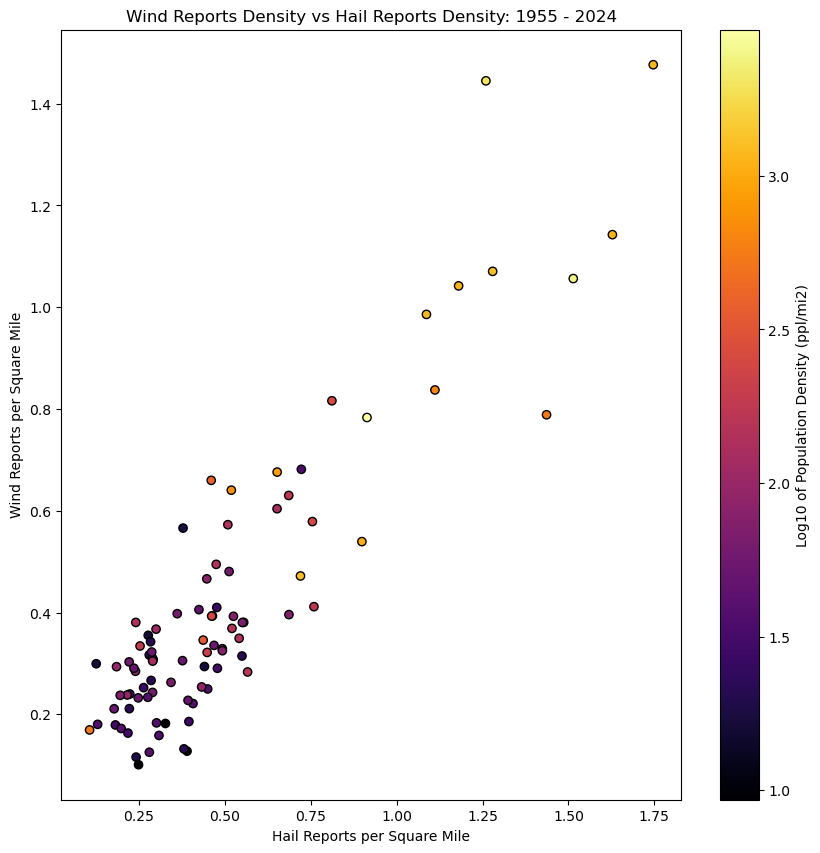

In [107]:
# Wind Reports Density vs Hail Reports Density
# color coded by population density

period_density_summary = county_stats[['Metro Area','Hail Reports Density rep/mi2','Wind Reports Density rep/mi2','Pop Density ppl/mi2','Log10 Pop Density ppl/mi2']]
log_pop_den = county_stats['Log10 Pop Density ppl/mi2']

cmap=plt.get_cmap('inferno')

fig,ax = plt.subplots(figsize=(10,10))

rep = ax.scatter(x=period_density_summary['Hail Reports Density rep/mi2'], y=period_density_summary['Wind Reports Density rep/mi2'], cmap = cmap, c = log_pop_den, ec='k')    

cb=fig.colorbar(rep)
cb.set_label('Log10 of Population Density (ppl/mi2)')

ax.set_xlabel('Hail Reports per Square Mile')
ax.set_ylabel('Wind Reports per Square Mile')
ax.set_title('Wind Reports Density vs Hail Reports Density: 1955 - 2024')

In [108]:
county_stats.head()

FIPS code       SED location           Census location Metro Area  \
0      17013  CALHOUN, ILLINOIS  Calhoun County, Illinois  St. Louis   
1      17061   GREENE, ILLINOIS   Greene County, Missouri  St. Louis   
2      17083   JERSEY, ILLINOIS   Jersey County, Illinois  St. Louis   
3      17119  MADISON, ILLINOIS  Madison County, Missouri  St. Louis   
4      17133   MONROE, ILLINOIS   Monroe County, Missouri  St. Louis   

    latitude  longitude  Pop Density ppl/mi2  Total Hail Reports  \
0  39.169265 -90.667578            17.362082                  32   
1  39.356181 -90.390471           551.102470                  58   
2  39.085513 -90.356520            58.161843                  82   
3  38.829738 -89.904933            17.646031                 271   
4  38.278542 -90.177390            22.546009                 108   

   Total Wind Reports  Hail Reports std  Wind Reports std  Area - Land mi2  \
0                  76          0.879488          1.576483          253.829   
1                  92          1.623839          1.583821          543.144   
2                 112          1.910849          1.852534          369.555   
3                 405          6.102794          6.097975          715.515   
4                 122          2.630290          2.224278          385.301   

   Hail Reports Density rep/mi2  Wind Reports Density rep/mi2  \
0                      0.126069                      0.299414   
1                      0.106786                      0.169384   
2                      0.221888                      0.303067   
3                      0.378748                      0.566026   
4                      0.280300                      0.316636   

   Hail Reports Density std  Wind Reports Density std  \
0                  0.003465                  0.006211   
1                  0.002990                  0.002916   
2                  0.005171                  0.005013   
3                  0.008529                  0.008522   
4                  0.006827                  0.005773   

   Log10 Pop Density ppl/mi2  
0                   1.239602  
1                   2.741232  
2                   1.764638  
3                   1.246647  
4                   1.353070

### Interannual Variability of Wind Reports Density and Hail Reports Density

Text(0.5, 1.0, 'Wind Reports Density vs Standard Deviation of Wind Reports Density: 1955 - 2024')

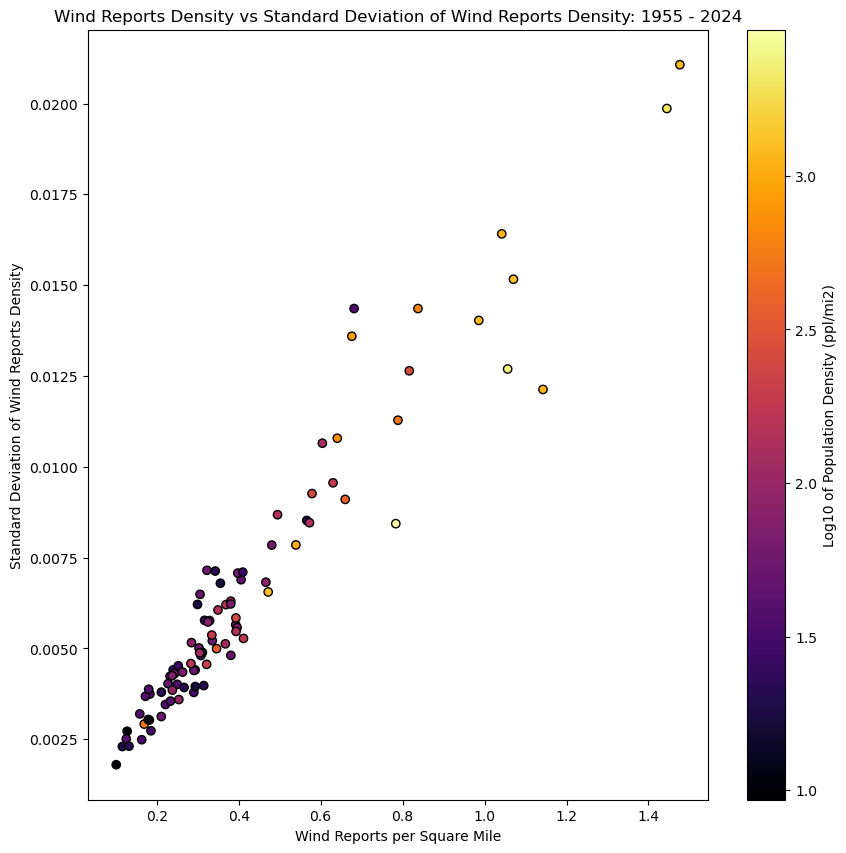

In [ ]:
# IS THE INTERANNUAL VARIABILITY IN REPORTS DENSITY CORRELATED WITH POPULATION DENSITY?

# Wind Reports Density vs Stdv of Wind Reports Density
# color coded by population density

interannual_density_summary = county_stats[['Metro Area','Hail Reports Density rep/mi2','Wind Reports Density rep/mi2','Hail Reports Density std','Wind Reports Density std','Pop Density ppl/mi2','Log10 Pop Density ppl/mi2']]
log_pop_den = county_stats['Log10 Pop Density ppl/mi2']

cmap=plt.get_cmap('inferno')

fig,ax = plt.subplots(figsize=(10,10))

rep = ax.scatter(x=interannual_density_summary['Wind Reports Density rep/mi2'], y=interannual_density_summary['Wind Reports Density std'], cmap = cmap, c = log_pop_den, ec='k')    

cb=fig.colorbar(rep)
cb.set_label('Log10 of Population Density (ppl/mi2)')

ax.set_xlabel('Wind Reports per Square Mile')
ax.set_ylabel('Standard Deviation of Wind Reports Density')
ax.set_title('Wind Reports Density vs Standard Deviation of Wind Reports Density: 1955 - 2024')


The linear relationship between wind reports density and its interannual variability is a good sign - we're not seeing high variability in counties with low reports density, which could suggest a strong influence from one or two large events rather than a consistent climatological signal (well, a climatological signal mediatied by population density-related reporting issues).

Text(0.5, 1.0, 'Hail Reports Density vs Standard Deviation of Hail Reports Density: 1955 - 2024')

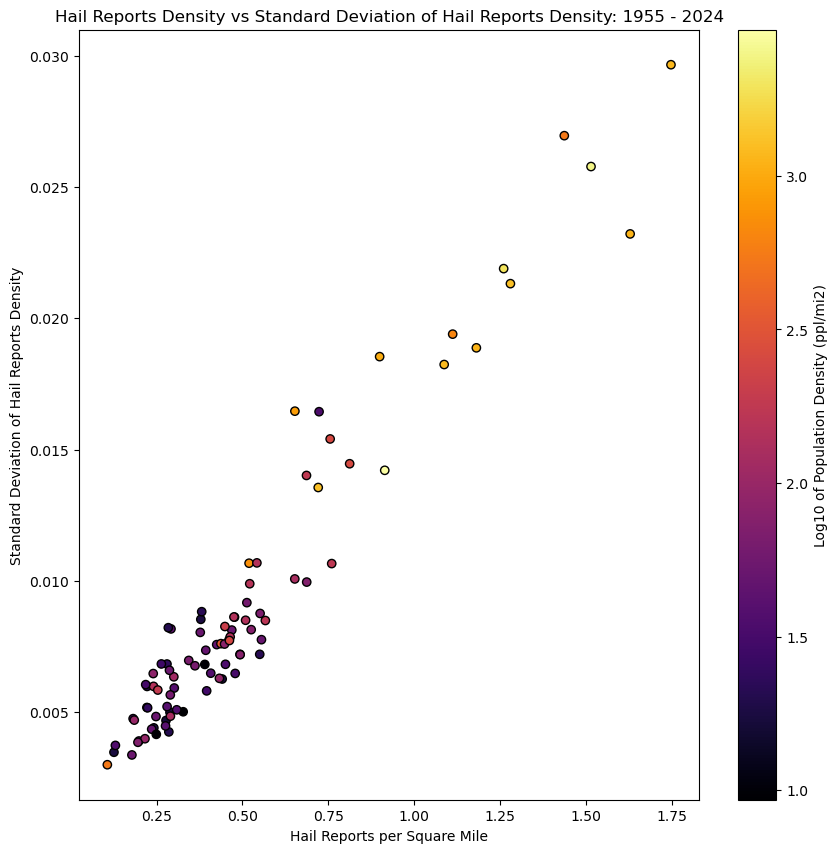

In [110]:
# Hail Reports Density vs Stdv of Hail Reports Density
# color coded by population density

interannual_density_summary = county_stats[['Metro Area','Hail Reports Density rep/mi2','Wind Reports Density rep/mi2','Hail Reports Density std','Wind Reports Density std','Pop Density ppl/mi2','Log10 Pop Density ppl/mi2']]
log_pop_den = county_stats['Log10 Pop Density ppl/mi2']

cmap=plt.get_cmap('inferno')

fig,ax = plt.subplots(figsize=(10,10))

rep = ax.scatter(x=interannual_density_summary['Hail Reports Density rep/mi2'], y=interannual_density_summary['Hail Reports Density std'], cmap = cmap, c = log_pop_den, ec='k')    

cb=fig.colorbar(rep)
cb.set_label('Log10 of Population Density (ppl/mi2)')

ax.set_xlabel('Hail Reports per Square Mile')
ax.set_ylabel('Standard Deviation of Hail Reports Density')
ax.set_title('Hail Reports Density vs Standard Deviation of Hail Reports Density: 1955 - 2024')

### Interannual Variability in Wind and Hail Reports by Metro Area

In [111]:
# LOOK AT STANDARD DEVATIONS OF REPORT DENSITIES BY METRO AREA
interannual_density_summary = county_stats[['Metro Area','Hail Reports Density rep/mi2','Wind Reports Density rep/mi2','Hail Reports Density std','Wind Reports Density std','Pop Density ppl/mi2','Log10 Pop Density ppl/mi2']]
interannual_density_summary_group = interannual_density_summary.groupby('Metro Area')

DFW
Kansas City
OKC
St. Louis
Tulsa 


Text(0.5, 1.0, 'Hail Reports Density vs Standard Deviation of Hail Reports Density: 1955 - 2024')

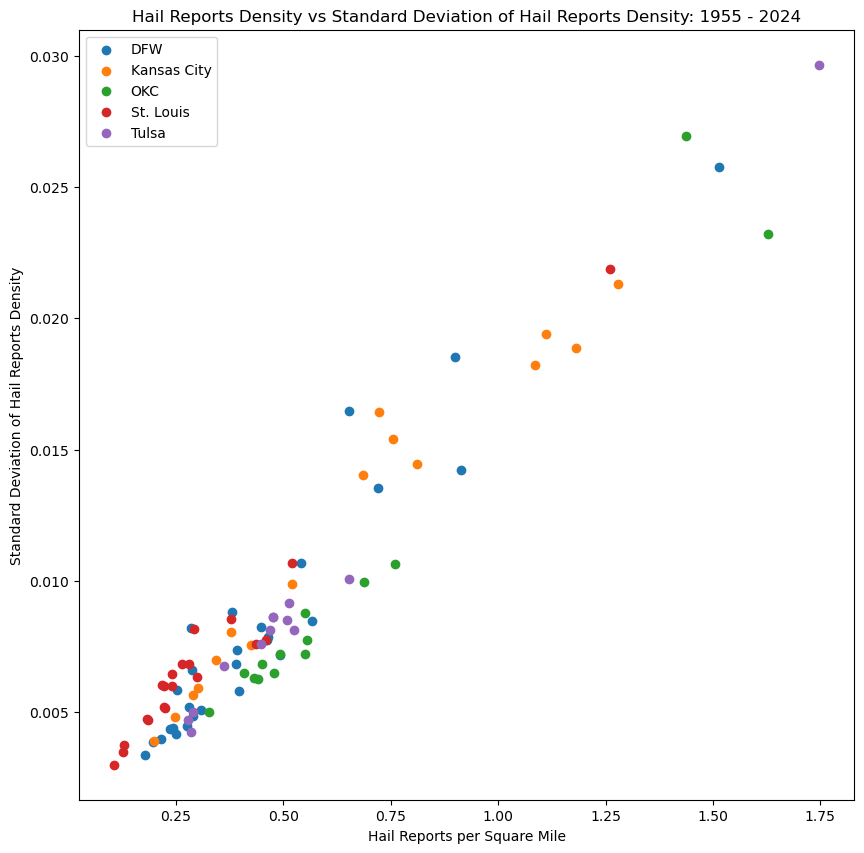

In [ ]:
# Wind Reports Density vs Wind Reports Density Std
# Color coded by metro area

fig,ax = plt.subplots(figsize=(10,10))

for city in cities:
    print(city)
    ax.scatter(x=interannual_density_summary_group.get_group(city)['Hail Reports Density rep/mi2'], y=interannual_density_summary_group.get_group(city)['Hail Reports Density std'], label = city)    

ax.legend()
ax.set_xlabel('Hail Reports per Square Mile')
ax.set_ylabel('Standard Deviation of Hail Reports Density')
ax.set_title('Hail Reports Density vs Standard Deviation of Hail Reports Density: 1955 - 2024')

We do see some regional clustering - more variability in hail reports densities in St. Louis than in OKC, for example.

## QUANTIFYING THE SIGNIFICANCE OF THE POPULATION BIAS

### Correlations between Population Density, Wind Reports Density, and Hail Reports Density

Text(0.5, 1.0, 'Pearsons Correlation Coefficients for Wind and Hail Reports Density and Population Density')

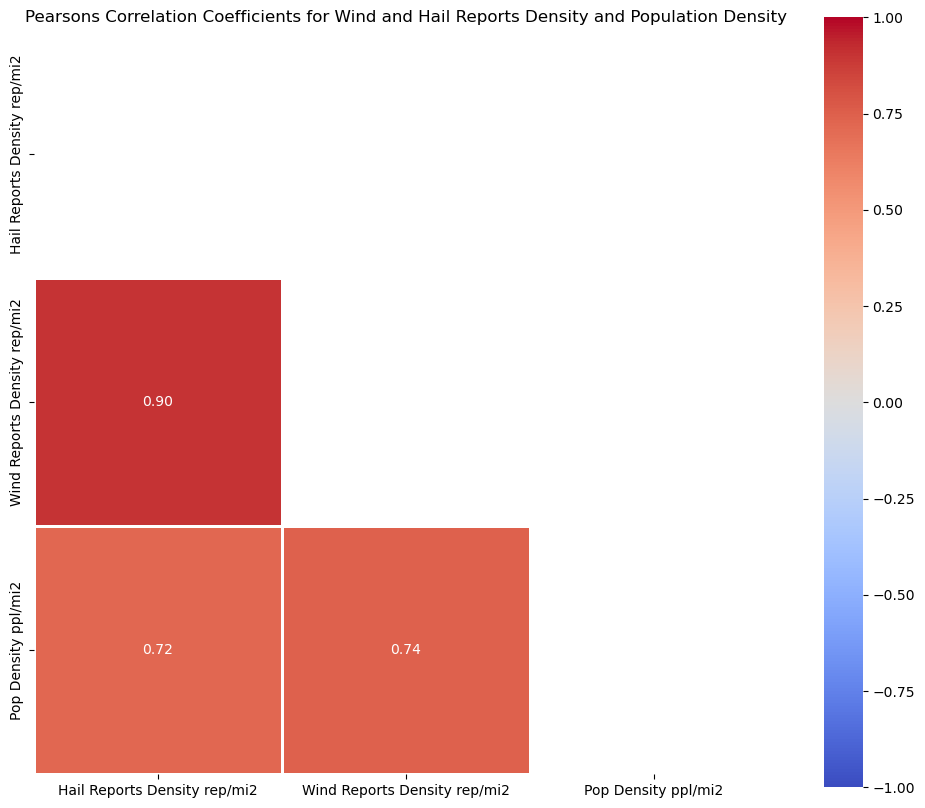

In [123]:
# Raw density metrics (no log)
# Calculating correlations
period_summary_sub_corr = county_stats[['Hail Reports Density rep/mi2','Wind Reports Density rep/mi2','Pop Density ppl/mi2']]
period_summary_corr = period_summary_sub_corr.corr() 
period_summary_corr.shape

# Creating mask for upper part of heatmap
mask = np.triu(np.ones_like(period_summary_corr, dtype=bool))

# Create heatmap
fig, ax = plt.subplots(figsize=(12, 10))

cmap = 'coolwarm' # keeping with the protip for colormap

per_cor = sb.heatmap(period_summary_corr, mask=mask,annot=True, fmt=".2f", 
          cmap=cmap, vmin=-1, vmax=1,
           square=True,linewidth=1)

ax.set_title('Pearsons Correlation Coefficients for Wind and Hail Reports Density and Population Density')

# Observations: All correlations went up when comparing reports density to population density (as opposed to raw number of reports to population density)

Strong correlations between population density and both hail reports density and wind reports density. Very strong correlation between wind reports density and hail reports density - this could be due to both climatology (each metro area was chosen because it experiences both severe hail and severe wind) as well as the fact that both are also related to population density.

### Mann-Whitney Test
Is there a statistically significant difference between the number of wind and hail reports per square mile in counties with high population densities vs counties with low population densities?

Assumption: regional differences are small enough (supported by EDA) that the data from all five metro areas can be combined. In other words, the influence of climatological differences between metro areas is significantly smaller than the influence of population density differences.

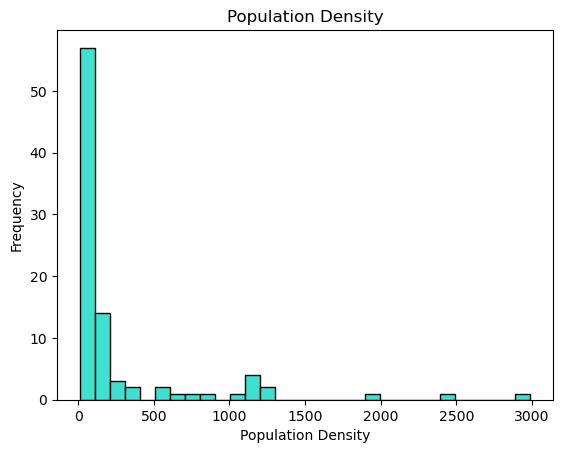

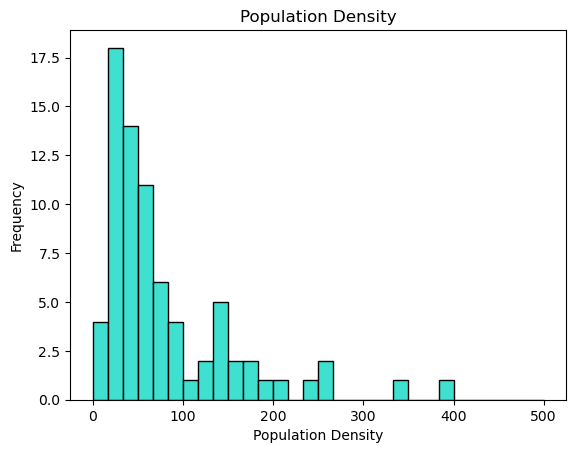

In [113]:
# Histogram of full population density dataset

pop_density = county_stats['Pop Density ppl/mi2']

# Set up histogram
plt.hist(pop_density, bins=30, color='turquoise', edgecolor='black')
 
# Adding labels and title
plt.xlabel('Population Density')
plt.ylabel('Frequency')
plt.title('Population Density')

plt.show()

# Zoomed in on low end of population density histogram
pop_density = county_stats['Pop Density ppl/mi2']

# Set up histogram
plt.hist(pop_density, bins=30, range = [0,500], color='turquoise', edgecolor='black')
 
# Adding labels and title
plt.xlabel('Population Density')
plt.ylabel('Frequency')
plt.title('Population Density')

plt.show()

# Lots of clustering at the low end of population density

In [114]:
# GROUP EACH COUNTY BY POPULATION DENSITY
# Tag each county with a density category 
# Create new population density category column

county_stats['Pop Cat'] = pd.Series(dtype = 'str')

county_stats.loc[county_stats['Pop Density ppl/mi2'] >= 1000, 'Pop Cat'] = 'urban'
county_stats.loc[county_stats['Pop Density ppl/mi2'] < 100, 'Pop Cat'] = 'rural'
county_stats.loc[(county_stats['Pop Density ppl/mi2'] >= 100) & (county_stats['Pop Density ppl/mi2'] < 1000), 'Pop Cat'] = 'suburban'

In [116]:
# WRITE OUT FINAL COUNTY_STATS DATAFRAME AGAIN
county_stats.to_csv(filepath_out+'county_stats.csv')

In [117]:
# Lets see how many counties qualify under each population density category
pop_cat_groups = county_stats.groupby('Pop Cat')
pop_cat_groups.size()

# Hopefully these groups are large enough for hypothesis testing and modeling
# Could always lump together urban and suburban (for total of 34 counties) to compare to rural (total of 57 counties)

Pop Cat
rural       57
suburban    24
urban       10
dtype: int64

['rural', 'suburban', 'urban']
rural
suburban
urban


Text(0.5, 1.0, 'Hail Reports vs Log10 Population Density: 1955 - 2024')

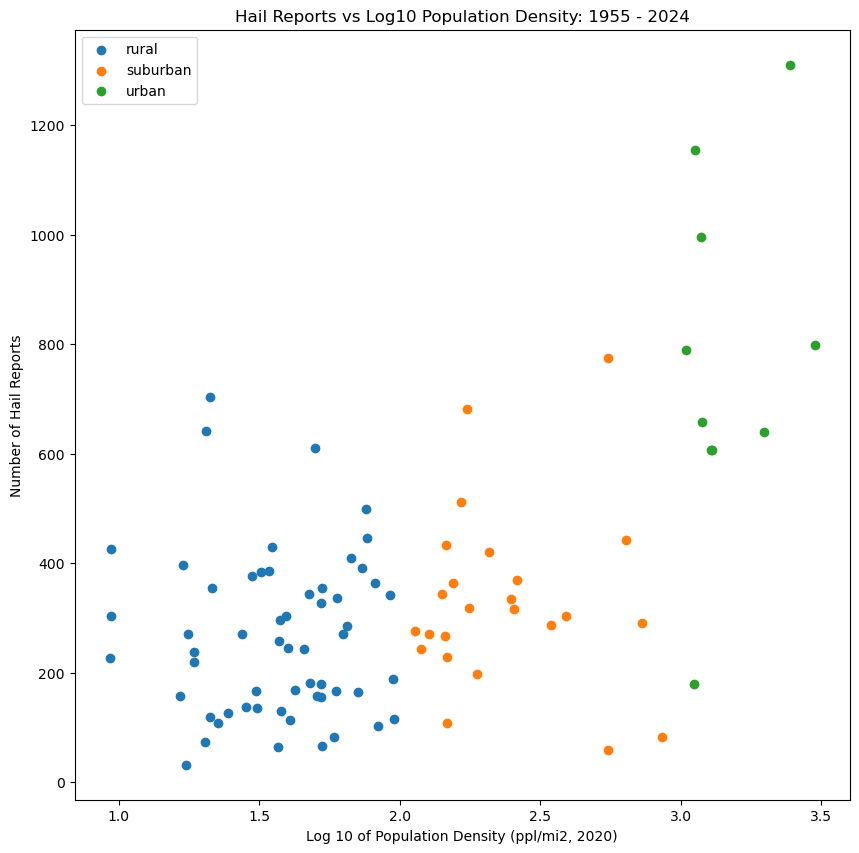

In [118]:
# PLOTTING TO SEE DISTRIBUTIONS
# Hail reports vs Population Density
pop_cats = list(pop_cat_groups.groups.keys())
print(pop_cats)

fig,ax = plt.subplots(figsize=(10,10))

for cat in pop_cats:
    print(cat)
    ax.scatter(x=pop_cat_groups.get_group(cat)['Log10 Pop Density ppl/mi2'], y=pop_cat_groups.get_group(cat)['Total Hail Reports'], label = cat)    

ax.legend()
ax.set_xlabel('Log 10 of Population Density (ppl/mi2, 2020)')
ax.set_ylabel('Number of Hail Reports')
ax.set_title('Hail Reports vs Log10 Population Density: 1955 - 2024')

['rural', 'suburban', 'urban']
rural
suburban
urban


Text(0.5, 1.0, 'Wind Reports vs Log10 Population Density: 1955 - 2024')

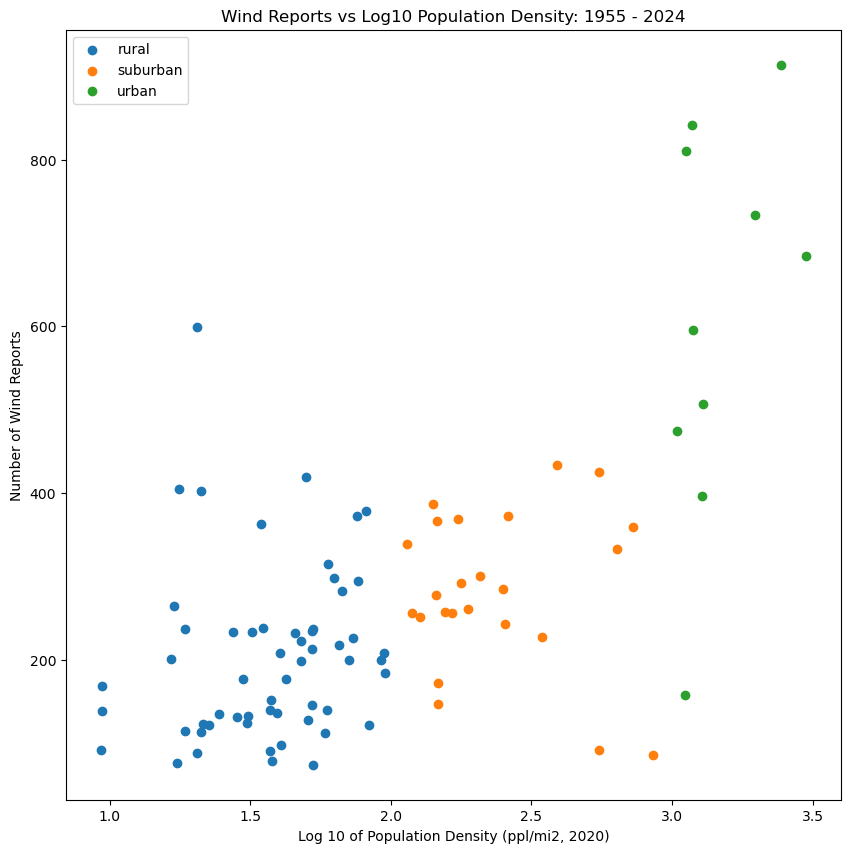

In [119]:
# Wind reports vs Population Density
pop_cats = list(pop_cat_groups.groups.keys())
print(pop_cats)

fig,ax = plt.subplots(figsize=(10,10))

for cat in pop_cats:
    print(cat)
    ax.scatter(x=pop_cat_groups.get_group(cat)['Log10 Pop Density ppl/mi2'], y=pop_cat_groups.get_group(cat)['Total Wind Reports'], label = cat)    

ax.legend()
ax.set_xlabel('Log 10 of Population Density (ppl/mi2, 2020)')
ax.set_ylabel('Number of Wind Reports')
ax.set_title('Wind Reports vs Log10 Population Density: 1955 - 2024')

rural
suburban
urban


Text(0.5, 1.0, 'Wind Reports vs Hail Reports: 1955 - 2024')

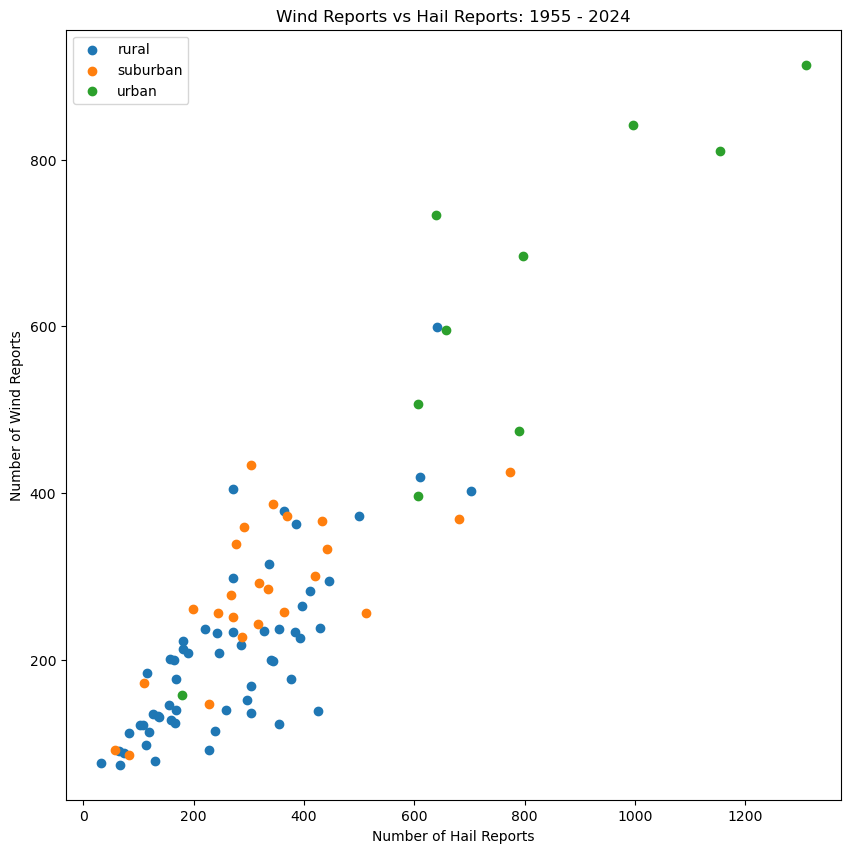

In [120]:
# Wind reports vs Hail Reports

fig,ax = plt.subplots(figsize=(10,10))

for cat in pop_cats:
    print(cat)
    ax.scatter(x=pop_cat_groups.get_group(cat)['Total Hail Reports'], y=pop_cat_groups.get_group(cat)['Total Wind Reports'], label = cat)    

ax.legend()
ax.set_xlabel('Number of Hail Reports')
ax.set_ylabel('Number of Wind Reports')
ax.set_title('Wind Reports vs Hail Reports: 1955 - 2024')

# Definetly some clustering by population density category, but it's not perfectly separable and clean

rural
suburban
urban


Text(0.5, 1.0, 'Wind Reports Density vs Hail Reports Density: 1955 - 2024')

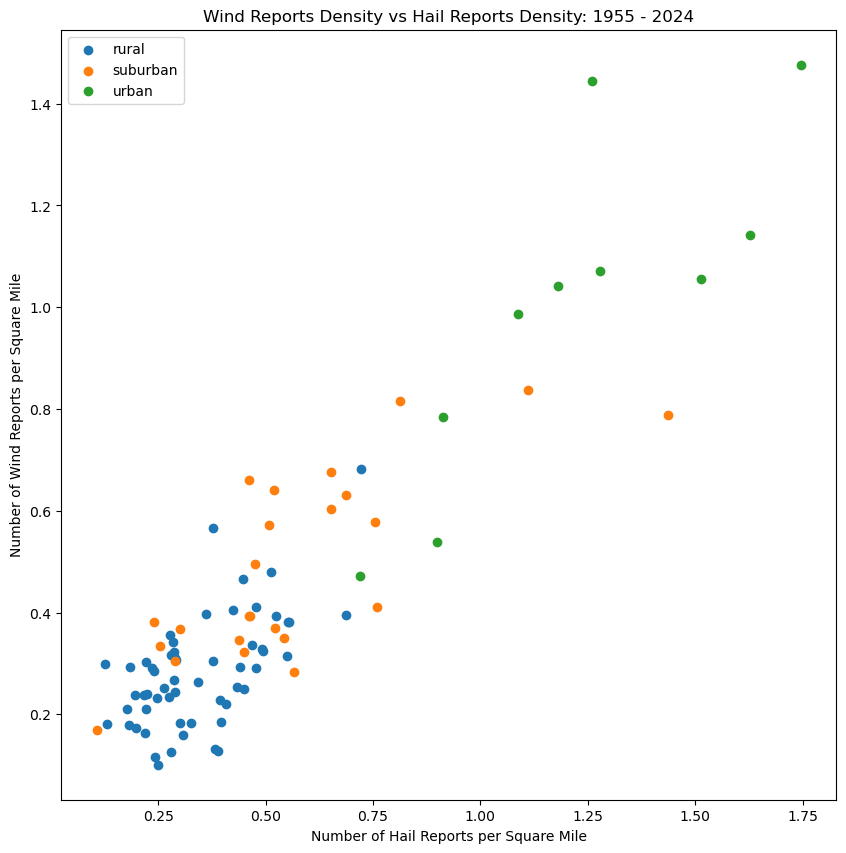

In [121]:
# Wind reports density vs Hail Reports density

fig,ax = plt.subplots(figsize=(10,10))

for cat in pop_cats:
    print(cat)
    ax.scatter(x=pop_cat_groups.get_group(cat)['Hail Reports Density rep/mi2'], y=pop_cat_groups.get_group(cat)['Wind Reports Density rep/mi2'], label = cat)    

ax.legend()
ax.set_xlabel('Number of Hail Reports per Square Mile')
ax.set_ylabel('Number of Wind Reports per Square Mile')
ax.set_title('Wind Reports Density vs Hail Reports Density: 1955 - 2024')

# Looks like a bit more separation by category - hypothesize that reports density will be a better predictor/feature for modeling than total number of reports 

## Hypothesis Testing: 
* Are storm reports densities significantly different among different population density categories?

In [124]:
# Create two categories to test
# 1) rural counties (total of 57)
# 2) suburban + urban counties (total of 24 + 10 = 34 counties)

rural_hypo = pop_cat_groups.get_group('rural')
urban_suburb_hypo = pd.concat([pop_cat_groups.get_group('urban'), pop_cat_groups.get_group('suburban')])

__Using a Mann-Whitney test because I have two samples, neither of which are normally distributed__ 
Will be running two tests:
1) hail reports density vs population density
2) wind reports density vs population density

In [126]:
rural_hypo.head()

FIPS code        SED location            Census location Metro Area  \
0      17013   CALHOUN, ILLINOIS   Calhoun County, Illinois  St. Louis   
2      17083    JERSEY, ILLINOIS    Jersey County, Illinois  St. Louis   
3      17119   MADISON, ILLINOIS   Madison County, Missouri  St. Louis   
4      17133    MONROE, ILLINOIS    Monroe County, Missouri  St. Louis   
5      17157  RANDOLPH, ILLINOIS  Randolph County, Missouri  St. Louis   

    latitude  longitude  Pop Density ppl/mi2  Total Hail Reports  \
0  39.169265 -90.667578            17.362082                  32   
2  39.085513 -90.356520            58.161843                  82   
3  38.829738 -89.904933            17.646031                 271   
4  38.278542 -90.177390            22.546009                 108   
5  38.052121 -89.825159            42.491140                 168   

   Total Wind Reports  Hail Reports std  Wind Reports std  Area - Land mi2  \
0                  76          0.879488          1.576483          253.829   
2                 112          1.910849          1.852534          369.555   
3                 405          6.102794          6.097975          715.515   
4                 122          2.630290          2.224278          385.301   
5                 177          4.697826          2.764796          575.367   

   Hail Reports Density rep/mi2  Wind Reports Density rep/mi2  \
0                      0.126069                      0.299414   
2                      0.221888                      0.303067   
3                      0.378748                      0.566026   
4                      0.280300                      0.316636   
5                      0.291988                      0.307630   

   Hail Reports Density std  Wind Reports Density std  \
0                  0.003465                  0.006211   
2                  0.005171                  0.005013   
3                  0.008529                  0.008522   
4                  0.006827                  0.005773   
5                  0.008165                  0.004805   

   Log10 Pop Density ppl/mi2 Pop Cat  
0                   1.239602   rural  
2                   1.764638   rural  
3                   1.246647   rural  
4                   1.353070   rural  
5                   1.628298   rural

In [127]:
# Hail reports are up first

# Start with two-sided test: are the distributions (rural vs suburan/urban) different, as represented by their medians?
two_side = stats.mannwhitneyu(x=rural_hypo['Hail Reports Density rep/mi2'], y = urban_suburb_hypo['Hail Reports Density rep/mi2'], alternative = 'two-sided')
print(two_side)

# Onto one-sided test: is the median of the rural distribution less than that of the suburban/urban distribution?
one_side = stats.mannwhitneyu(x=rural_hypo['Hail Reports Density rep/mi2'], y = urban_suburb_hypo['Hail Reports Density rep/mi2'], alternative = 'less')
print(one_side)

# Look at those teeny-tiny p-values!
# Conclusions: reject the null hypothesis in both cases
# 1) the distributions of hail reports per square mile are different between rural counties and suburban/urban counties (from two-sided test)
# 2) hail reports density tends to be lower in rural counties than in suburban/urban counties (from one-sided test)

MannwhitneyuResult(statistic=np.float64(307.0), pvalue=np.float64(5.7349851051714124e-08))
MannwhitneyuResult(statistic=np.float64(307.0), pvalue=np.float64(2.8674925525857062e-08))


In [128]:
# Now on to wind reports

# Start with two-sided test: are the distributions (rural vs suburan/urban) different, as represented by their medians?
two_side = stats.mannwhitneyu(x=rural_hypo['Wind Reports Density rep/mi2'], y = urban_suburb_hypo['Wind Reports Density rep/mi2'], alternative = 'two-sided')
print(two_side)

# Onto one-sided test: is the median of the rural distribution less than that of the suburban/urban distribution?
one_side = stats.mannwhitneyu(x=rural_hypo['Wind Reports Density rep/mi2'], y = urban_suburb_hypo['Wind Reports Density rep/mi2'], alternative = 'less')
print(one_side)

# Even tinier p-values!
# Conclusions: reject the null hypothesis in both cases
# 1) the distributions of wind reports per square mile are different between rural counties and suburban/urban counties (from two-sided test)
# 2) wind reports density tends to be lower in rural counties than in suburban/urban counties (from one-sided test)

MannwhitneyuResult(statistic=np.float64(222.0), pvalue=np.float64(9.113817975400816e-10))
MannwhitneyuResult(statistic=np.float64(222.0), pvalue=np.float64(4.556908987700408e-10))


### Conclusion: There is a statistically significant difference in the number of severe wind and hail reports in counties with a high population density vs in counties with a low population density.

## Examining the Findings Geographically
Clear parallels in the spatial patterns of maximum population density, wind reports density, and hail reports density

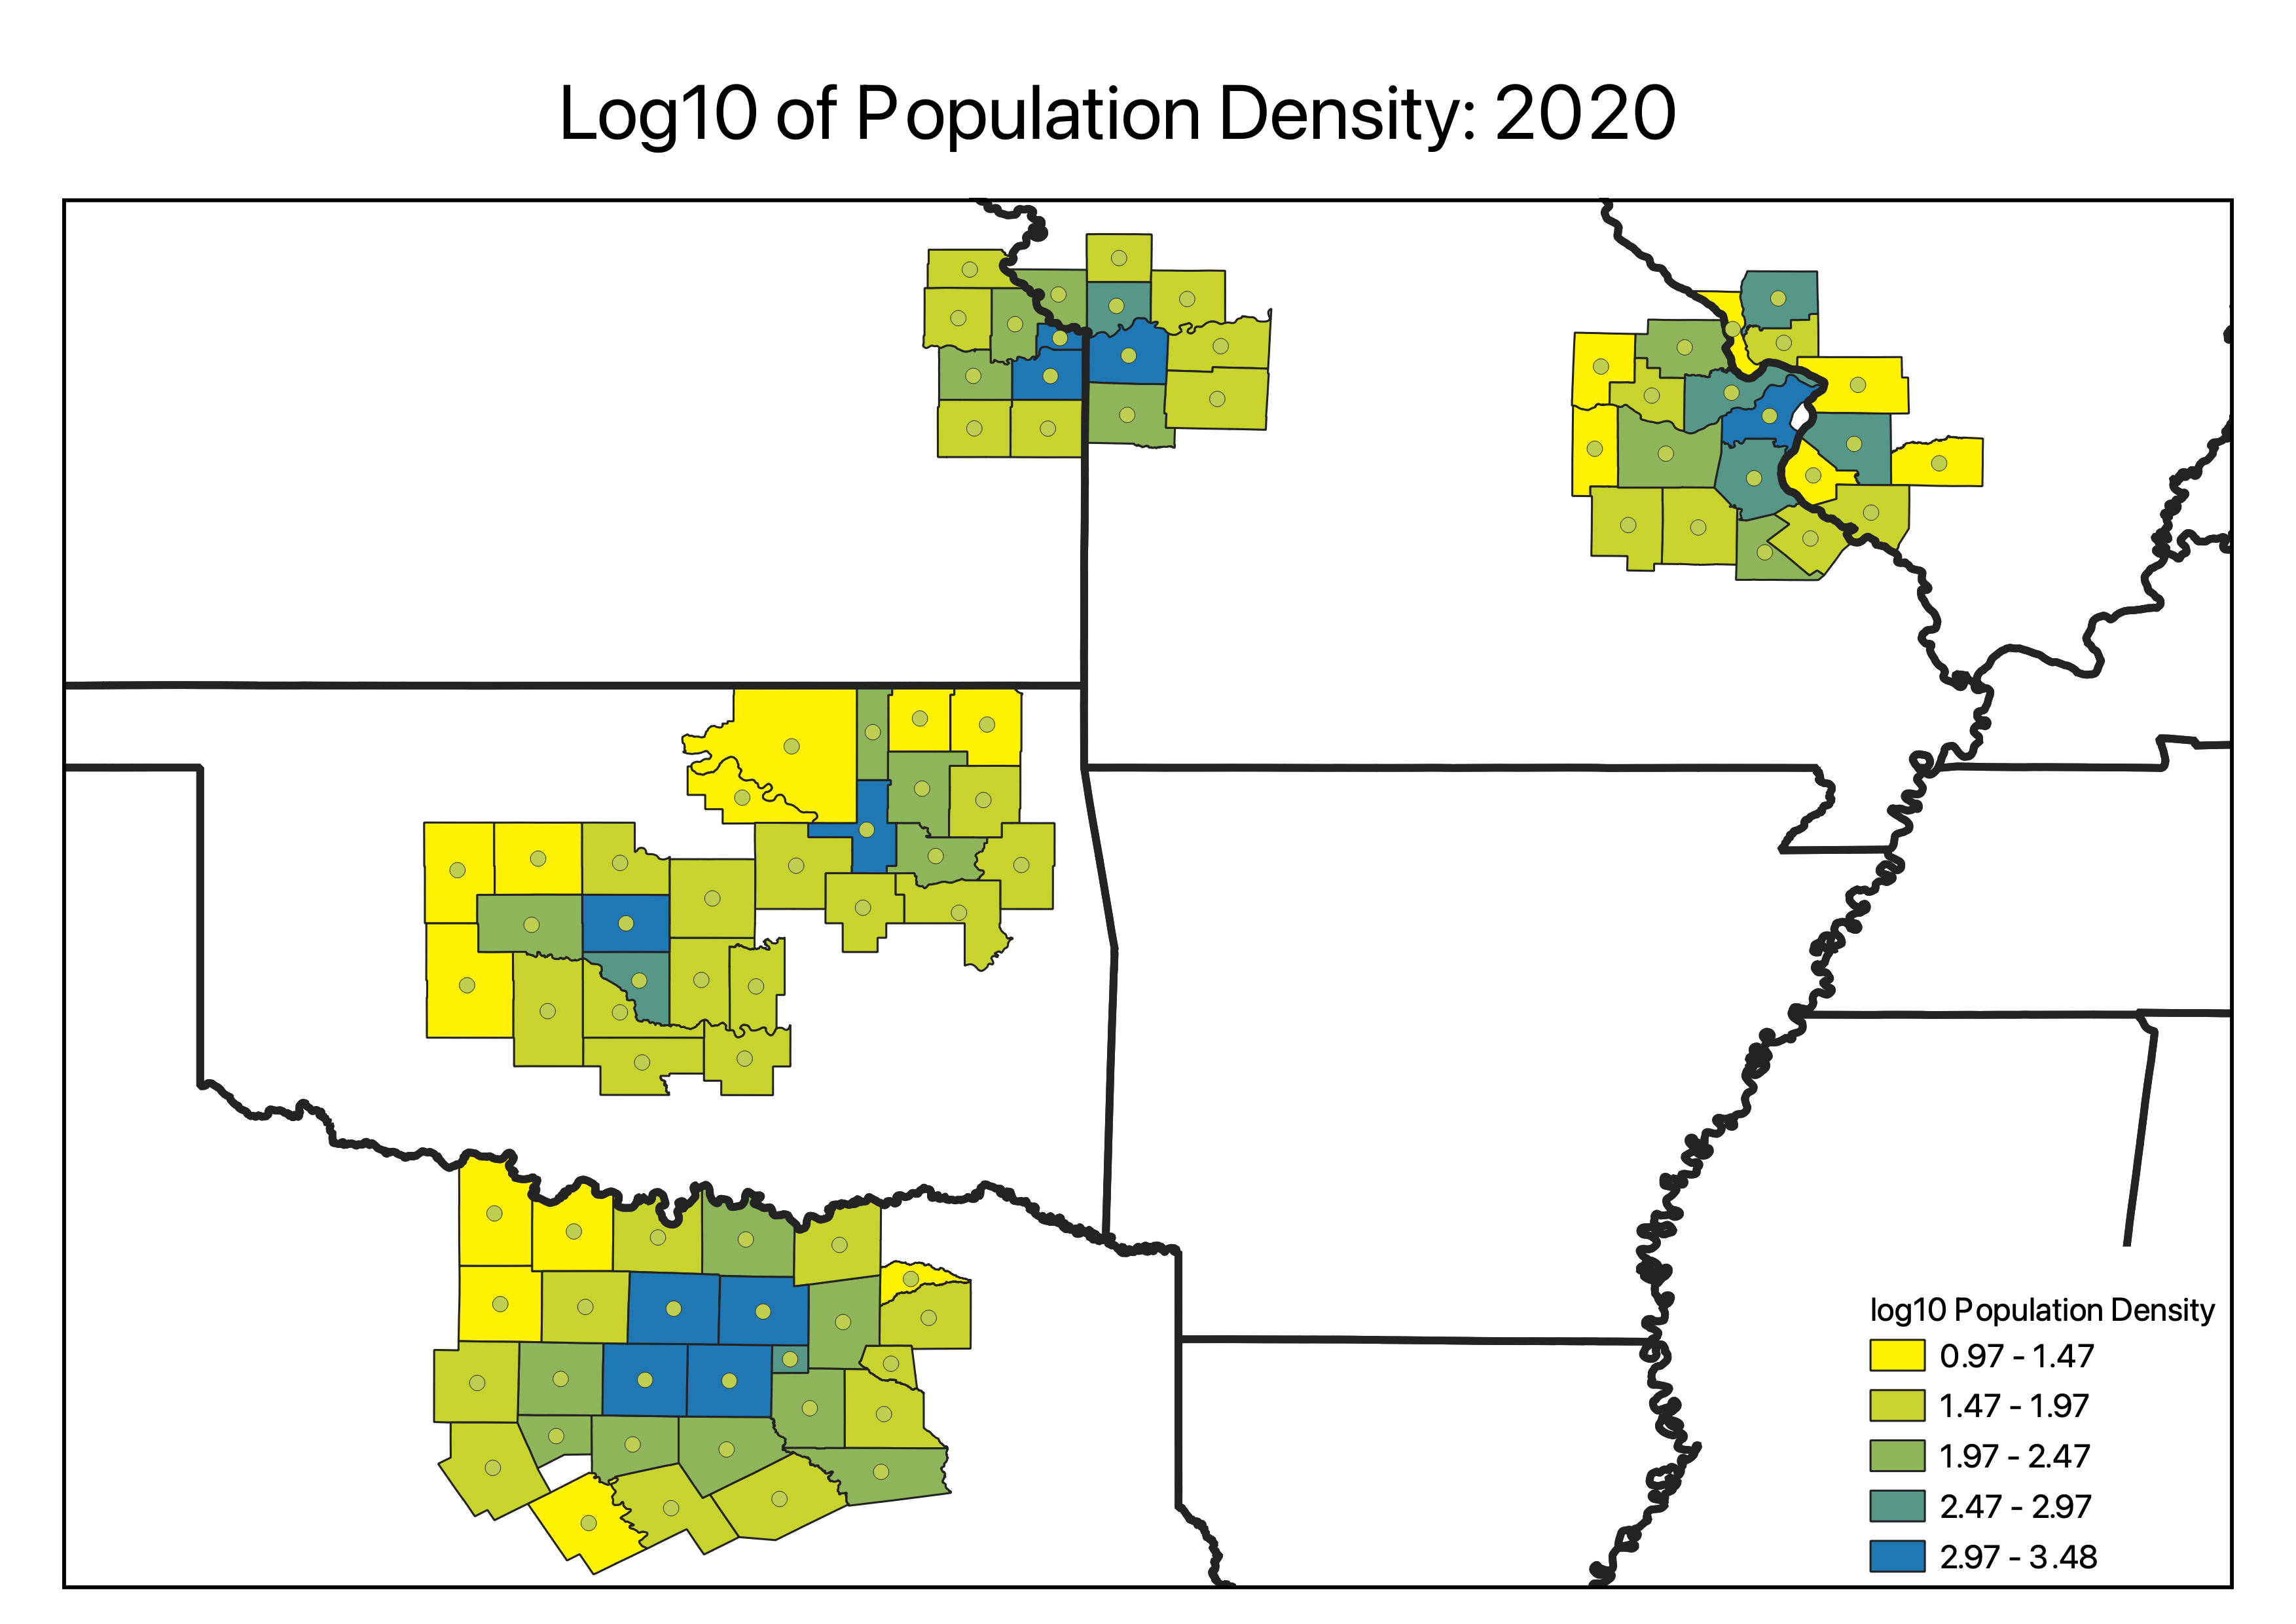

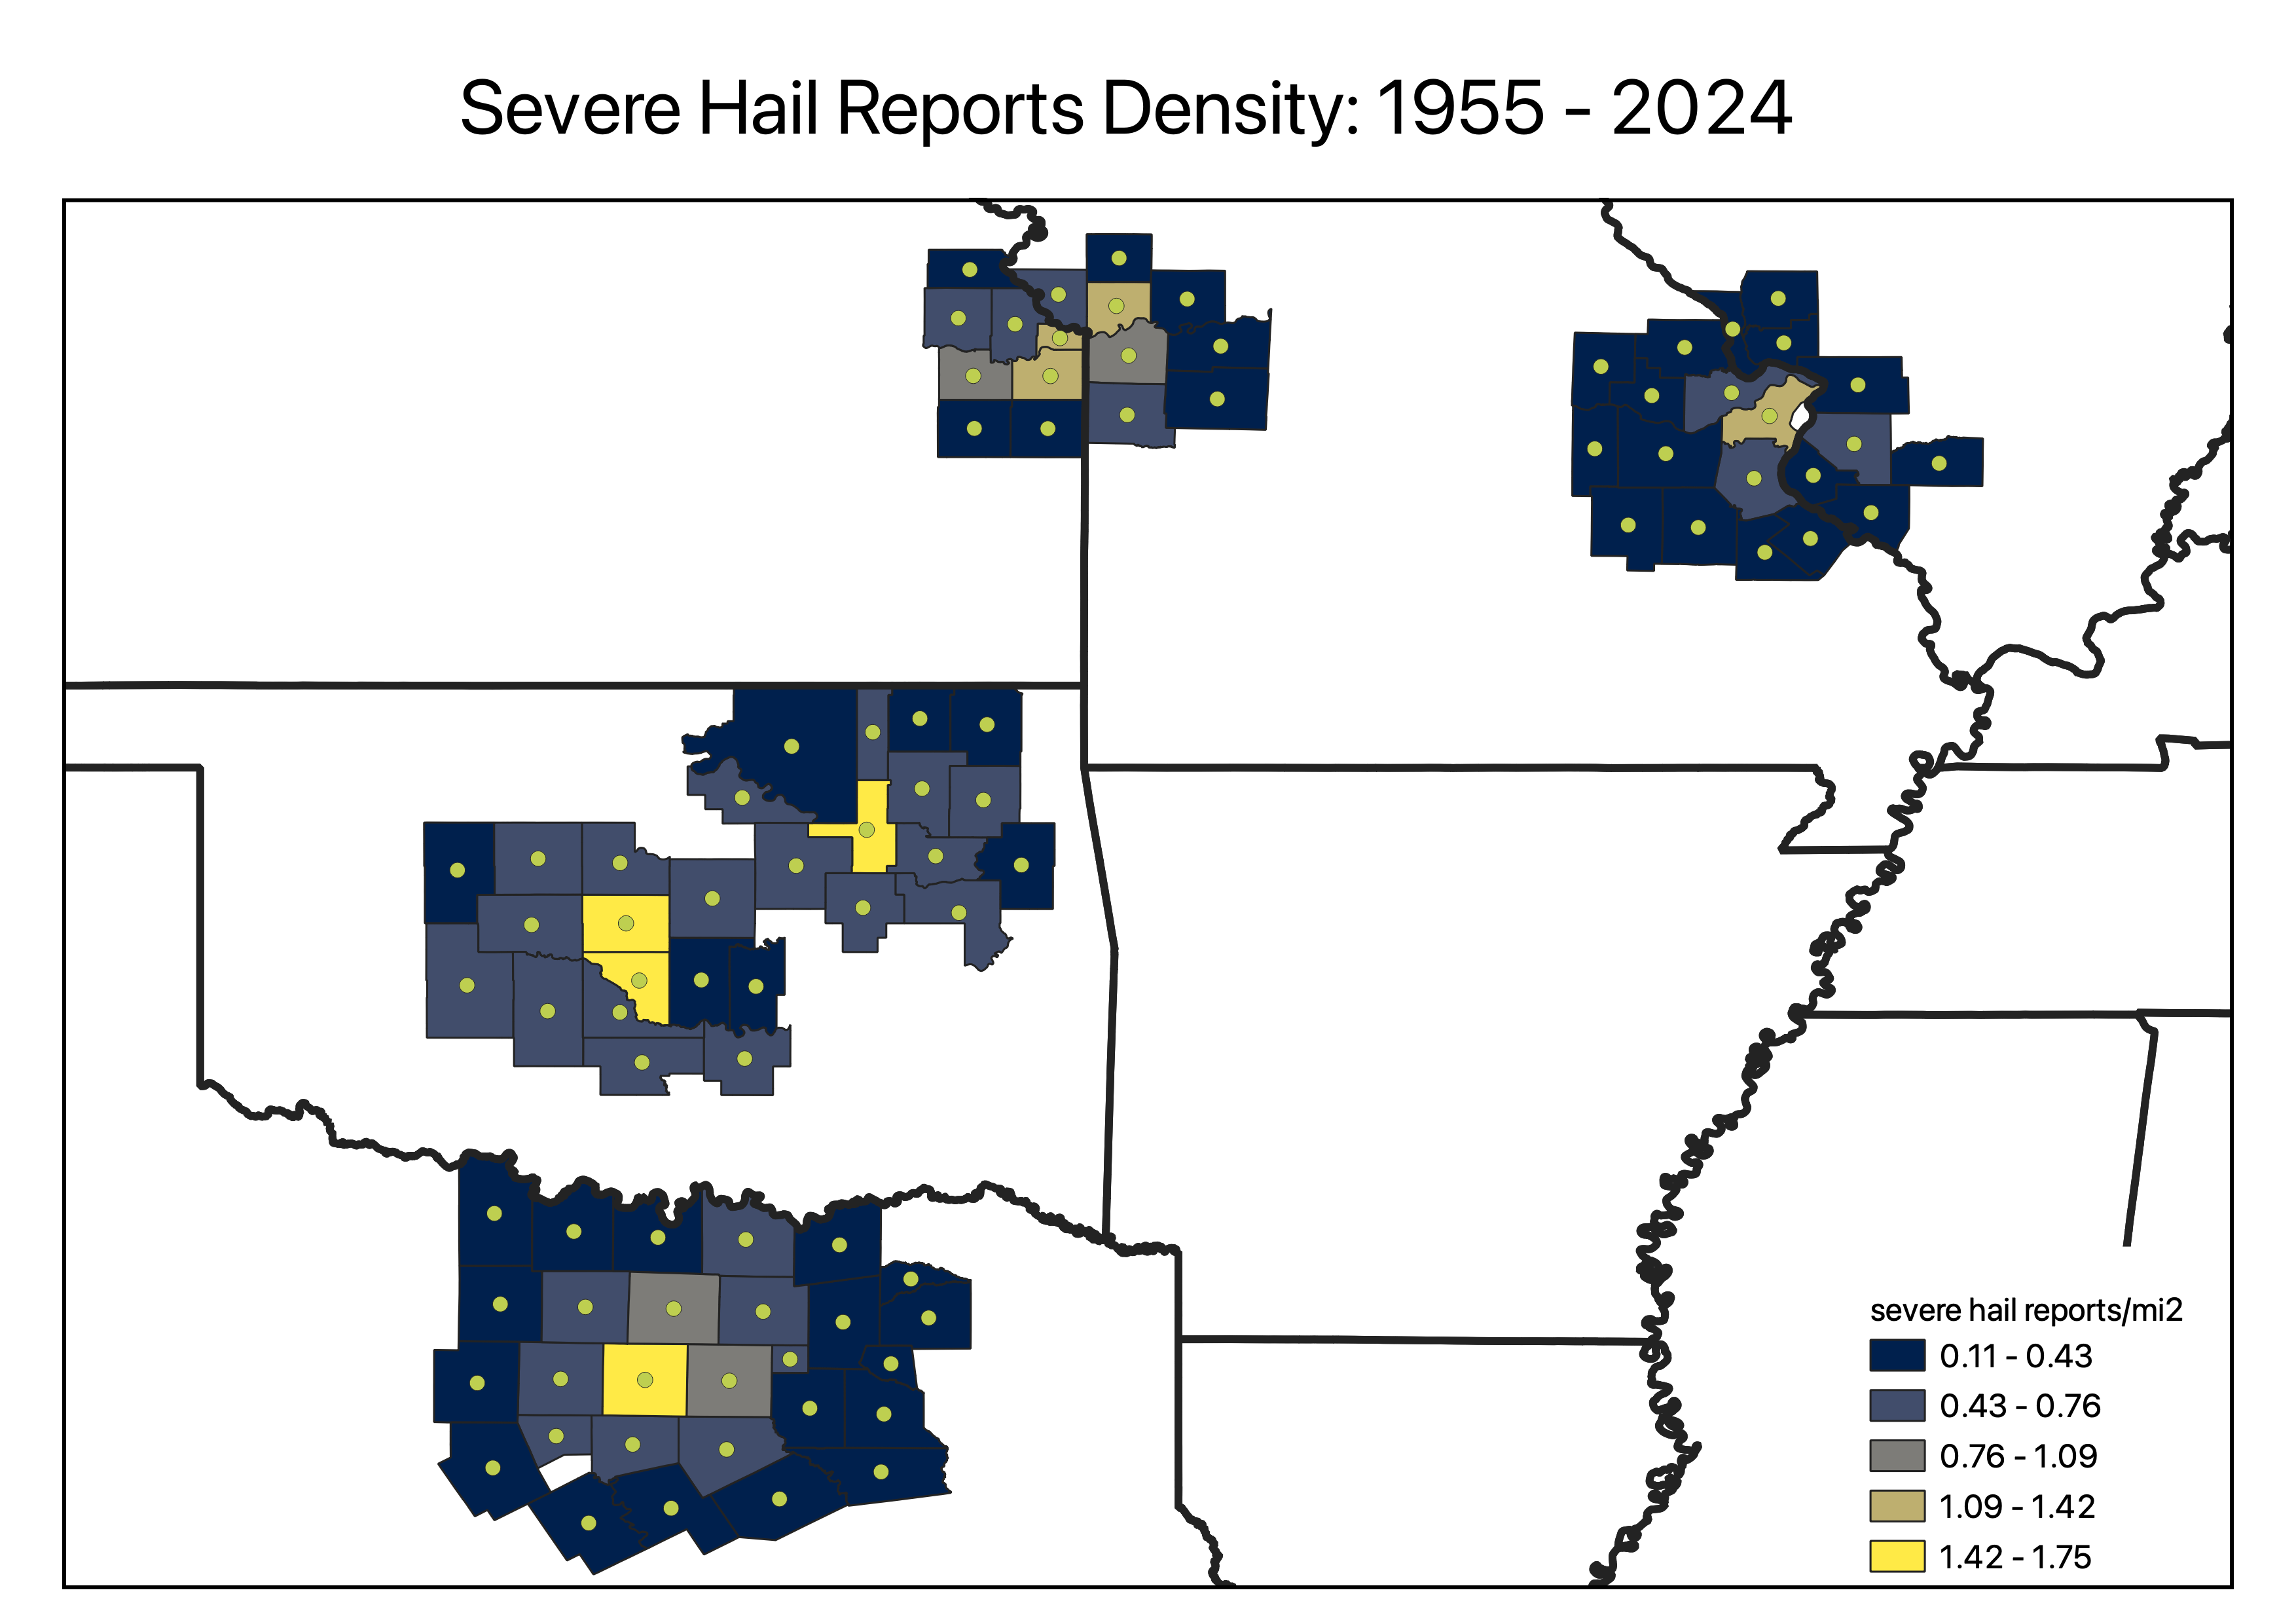

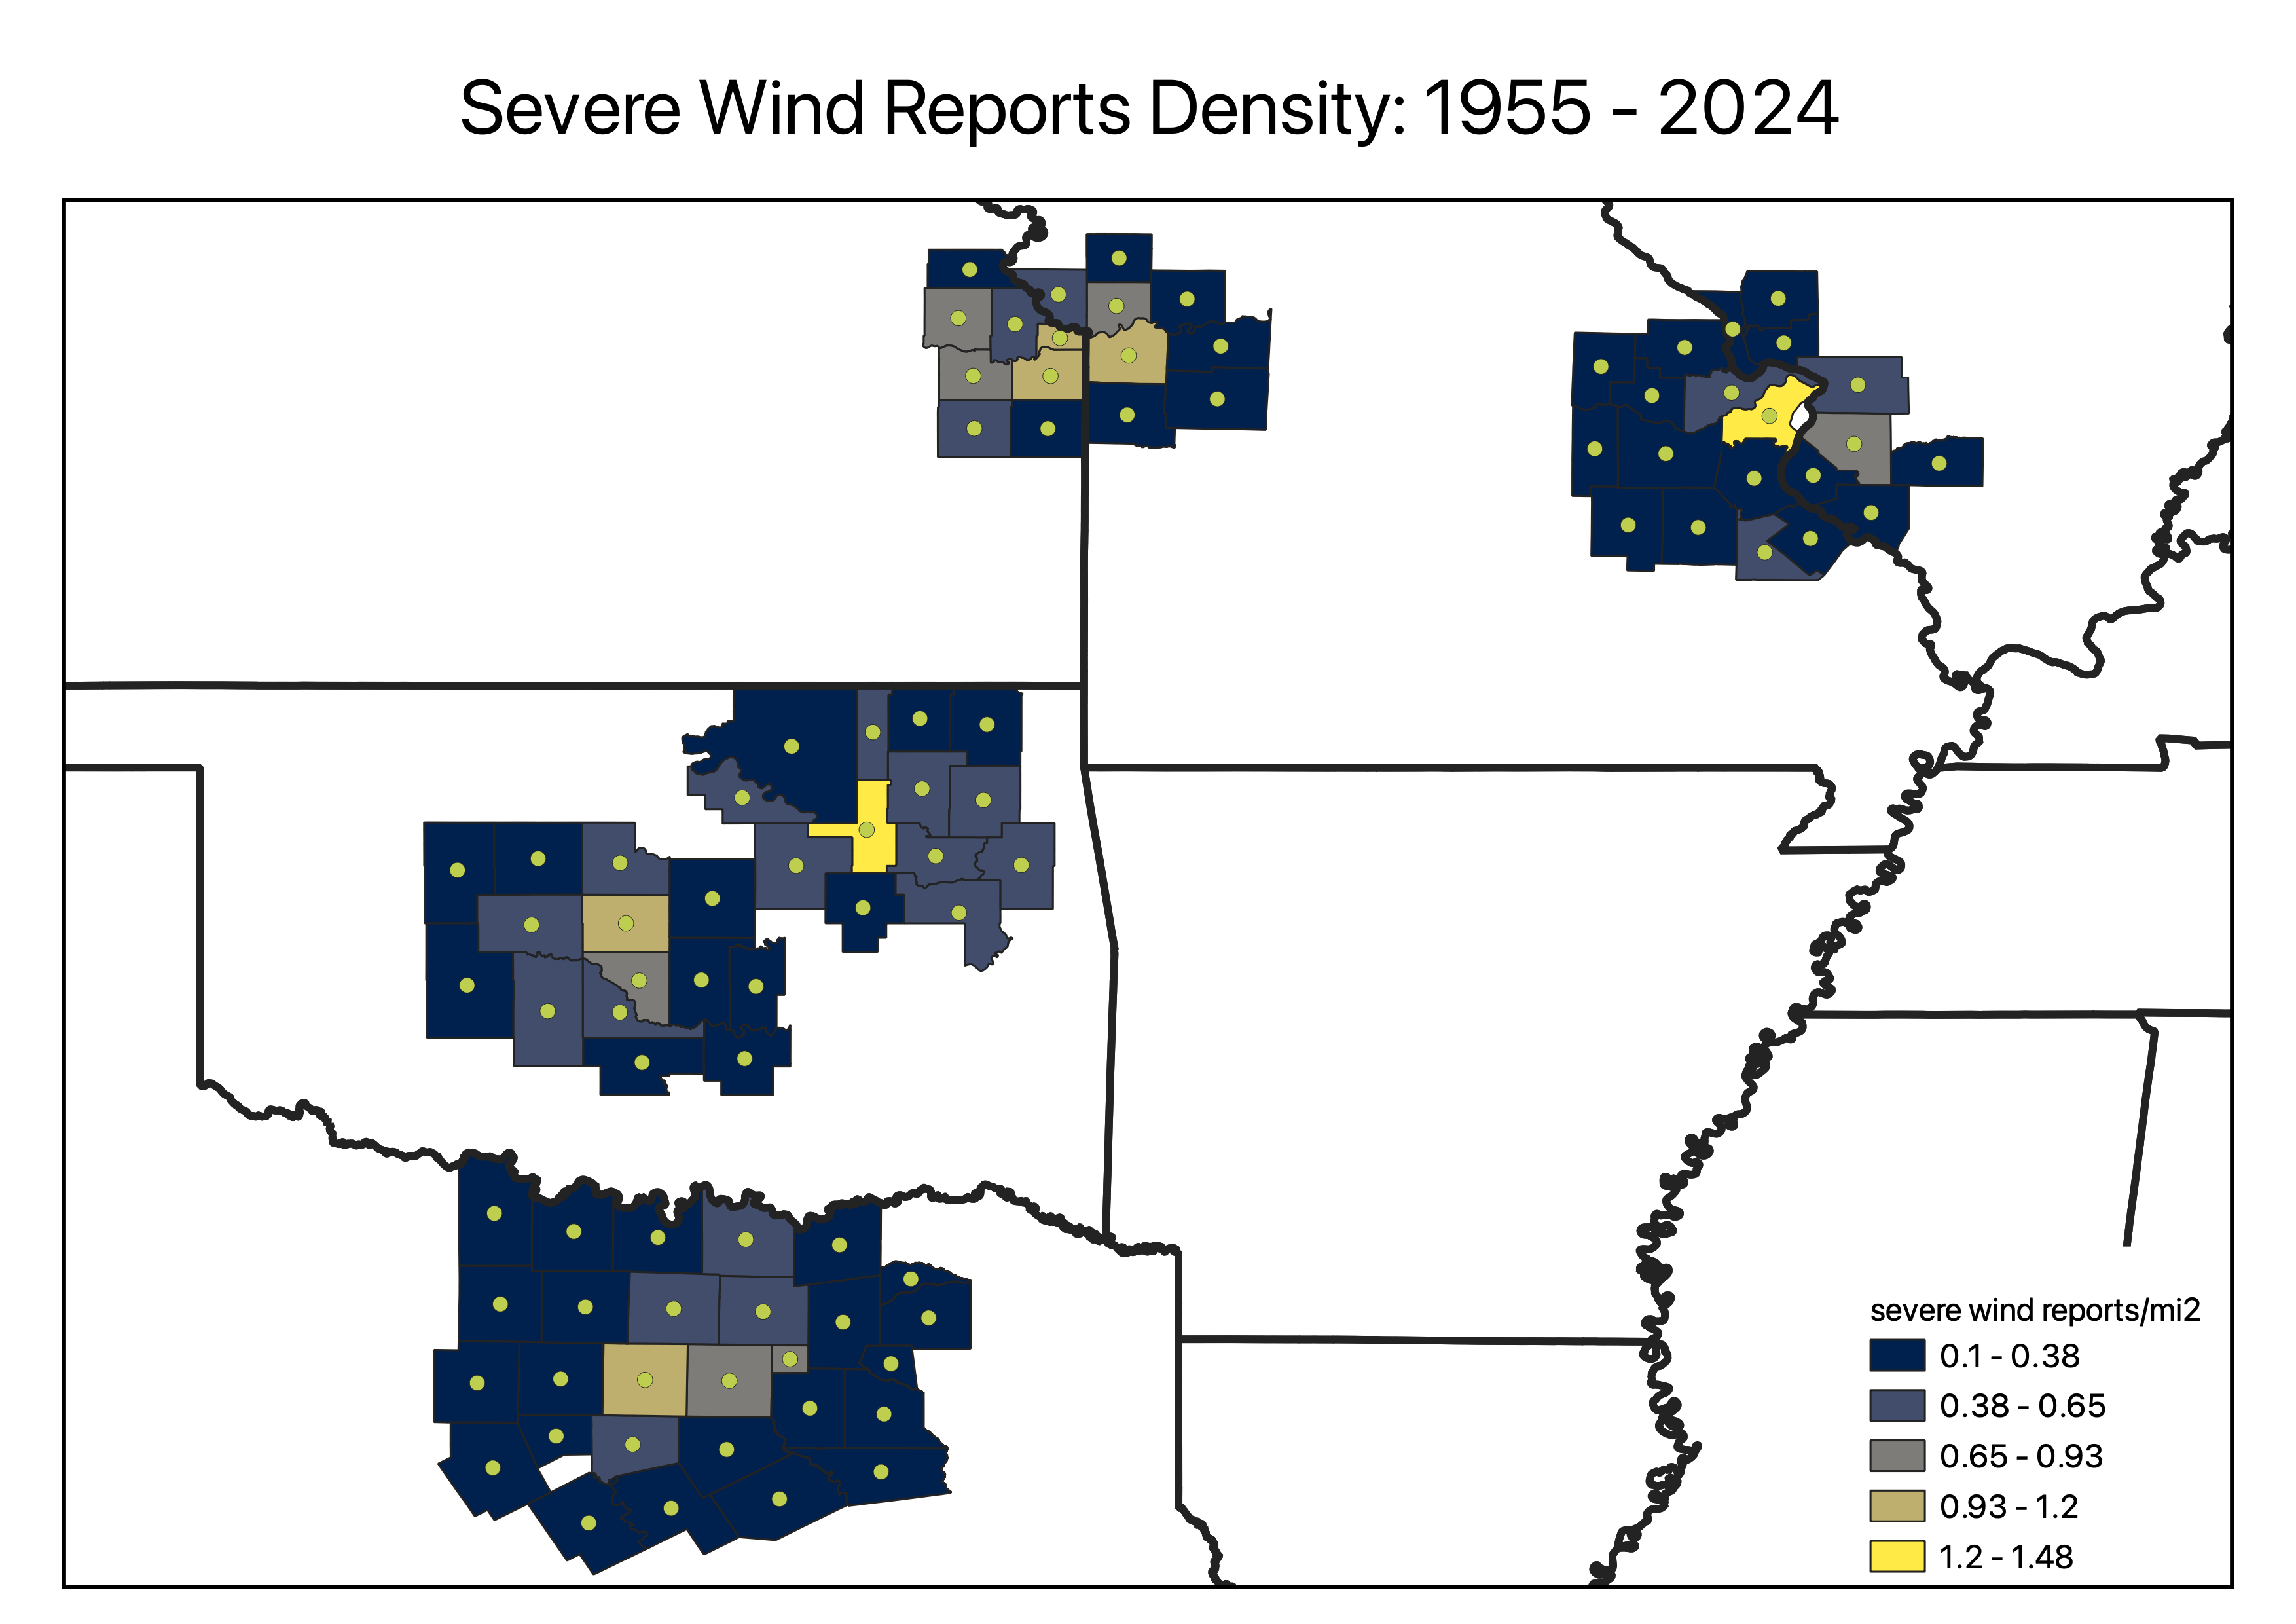

## Time for Some Modeling

### Overview
Features: 
- latitude
- longitude
- population density
- WWA density 
- ultimately, I want to see if WWA density and population density alone can predict storm report density (better chance of this working when I can use hail and wind tags)

Targets:
- hail reports density
- wind reports density

Wind and hail will be modeled separately at first - can wind reports density be calculated just with lat, lon, and population density? Same question with hail reports density. The lat/lon portion here is basically a substitute for WWA density - it sets the climo by implicitly assuming that in the population centers, all severe wx that occurred was, in fact, reported. So for whichever city center is closest, that's the amount of severe wx that actually happened - then use pop density to scale for how much was likely reported (account for population bias)

Then I'll use hail reports density as a feature to attempt to predict wind reports density and vice versa (since the data show that wind reports and hail reports densities are highly correlated)

__Ultimate Goal__
<p>
Calculate a population "scale factor" that can be used to assess the actual frequency of severe wx occurrence based on WWAs _or_ lat/lon and population density. I'm essentially calculating the "missing" reports - those occurrences of severe wx that go unreported due to lack of observers to report it.



### Modeling Attempt #1
Basing this off of the Module 5 rainrate and Module 6 tornado examples that used a Random Forest Regression for prediction of meteorological variables.

In [131]:
# Import libraries for modeling
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error, mean_absolute_error
from ipywidgets import interact, IntSlider, FloatSlider, Dropdown, VBox, HBox, fixed, Output
from IPython.display import display, HTML

In [144]:
county_stats.head()

FIPS code       SED location           Census location Metro Area  \
0      17013  CALHOUN, ILLINOIS  Calhoun County, Illinois  St. Louis   
1      17061   GREENE, ILLINOIS   Greene County, Missouri  St. Louis   
2      17083   JERSEY, ILLINOIS   Jersey County, Illinois  St. Louis   
3      17119  MADISON, ILLINOIS  Madison County, Missouri  St. Louis   
4      17133   MONROE, ILLINOIS   Monroe County, Missouri  St. Louis   

    latitude  longitude  Pop Density ppl/mi2  Total Hail Reports  \
0  39.169265 -90.667578            17.362082                  32   
1  39.356181 -90.390471           551.102470                  58   
2  39.085513 -90.356520            58.161843                  82   
3  38.829738 -89.904933            17.646031                 271   
4  38.278542 -90.177390            22.546009                 108   

   Total Wind Reports  Hail Reports std  Wind Reports std  Area - Land mi2  \
0                  76          0.879488          1.576483          253.829   
1                  92          1.623839          1.583821          543.144   
2                 112          1.910849          1.852534          369.555   
3                 405          6.102794          6.097975          715.515   
4                 122          2.630290          2.224278          385.301   

   Hail Reports Density rep/mi2  Wind Reports Density rep/mi2  \
0                      0.126069                      0.299414   
1                      0.106786                      0.169384   
2                      0.221888                      0.303067   
3                      0.378748                      0.566026   
4                      0.280300                      0.316636   

   Hail Reports Density std  Wind Reports Density std  \
0                  0.003465                  0.006211   
1                  0.002990                  0.002916   
2                  0.005171                  0.005013   
3                  0.008529                  0.008522   
4                  0.006827                  0.005773   

   Log10 Pop Density ppl/mi2   Pop Cat  
0                   1.239602     rural  
1                   2.741232  suburban  
2                   1.764638     rural  
3                   1.246647     rural  
4                   1.353070     rural

In [ ]:
# Separate features and targets
features = county_stats[['latitude','longitude','Pop Density ppl/mi2']]
features_wind = county_stats['Wind Reports Density rep/mi2']
features_hail = county_stats['Hail Reports Density rep/mi2']

In [138]:
# Set variables for modeling
X = features
y_wind = features_wind
y_hail = features_hail

X.shape, y_wind.shape, y_hail.shape

((91, 3), (91,), (91,))

In [139]:
# Split the training and testing data
# Reserve 25% of the data for testing
# We're not working with much data here - just 91 counties total, so it make take some playing around to find the best test/train split

# Wind
X_train_wind, X_test_wind, y_train_wind, y_test_wind = train_test_split(X, y_wind, test_size=0.25, random_state=42)
print('Wind train size:', X_train_wind.shape, 'Wind test size:', X_test_wind.shape)

# Hail
X_train_hail, X_test_hail, y_train_hail, y_test_hail = train_test_split(X, y_hail, test_size=0.25, random_state=42)
print('Hail train size:', X_train_hail.shape, 'Hail test size:', X_test_hail.shape)

Wind train size: (68, 3) Wind test size: (23, 3)
Hail train size: (68, 3) Hail test size: (23, 3)


RMSE: 0.34
RMSE as fraction of observed std dev: 1.15
Correlation Coefficient: 0.95


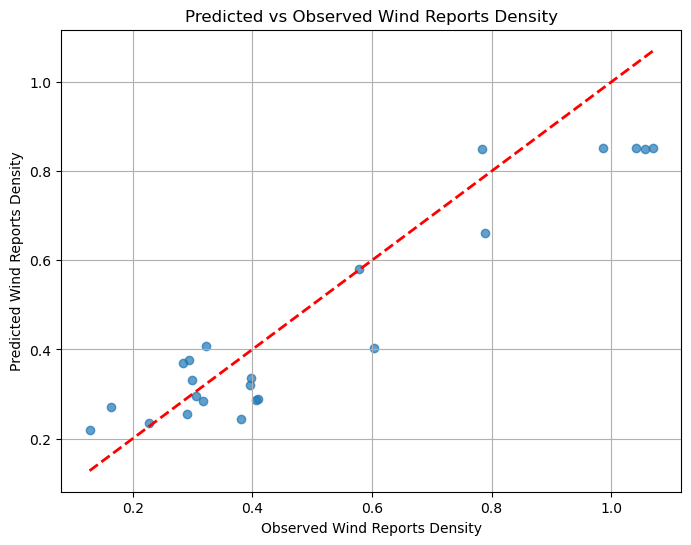

In [142]:
# Fit the random forest regression model
# Wind first
forest_wind = RandomForestRegressor(n_estimators=100, min_samples_leaf=5, max_depth=10, random_state=42)
forest_wind.fit(X_train_wind, y_train_wind)

# Use the model to make predictions on the test set
y_pred_wind = forest_wind.predict(X_test_wind)

# Evaluate model performance
rmse = np.sqrt(root_mean_squared_error(y_test_wind, y_pred_wind))
print(f'RMSE: {rmse:.2f}')
# RMSE as a fraction of the standard deviation of the observed values
rmse_frac = rmse / np.std(y_test_wind)
print(f'RMSE as fraction of observed std dev: {rmse_frac:.2f}')
corr_coef = np.corrcoef(y_test_wind, y_pred_wind)[0, 1]
print(f'Correlation Coefficient: {corr_coef:.2f}')

# Plot predicted vs observed tornado counts
plt.figure(figsize=(8, 6))
plt.scatter(y_test_wind, y_pred_wind, alpha=0.7)
plt.plot([y_test_wind.min(), y_test_wind.max()], [y_test_wind.min(), y_test_wind.max()], 'r--', lw=2)
plt.xlabel('Observed Wind Reports Density')
plt.ylabel('Predicted Wind Reports Density')
plt.title('Predicted vs Observed Wind Reports Density')
plt.grid()
plt.show()

RMSE: 0.46
RMSE as fraction of observed std dev: 1.14
Correlation Coefficient: 0.91


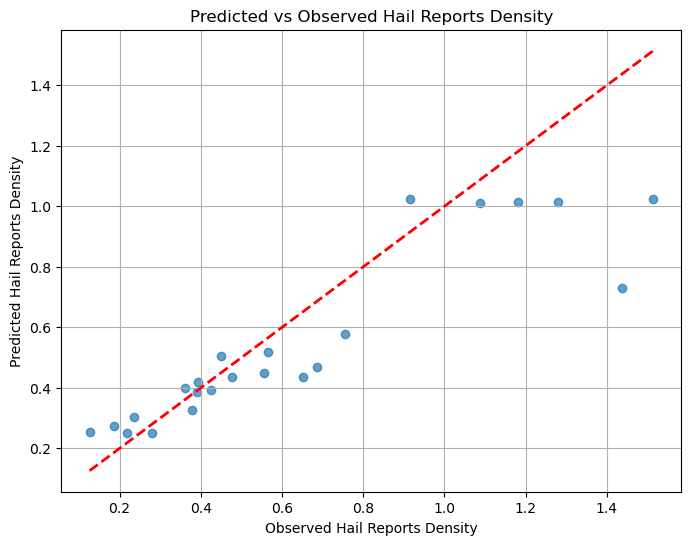

In [143]:
# Fit the random forest regression model
# Hail next

forest_hail = RandomForestRegressor(n_estimators=100, min_samples_leaf=5, max_depth=10, random_state=42)
forest_hail.fit(X_train_hail, y_train_hail)

# Use the model to make predictions on the test set
y_pred_hail = forest_hail.predict(X_test_hail)

# Evaluate model performance
rmse = np.sqrt(root_mean_squared_error(y_test_hail, y_pred_hail))
print(f'RMSE: {rmse:.2f}')
# RMSE as a fraction of the standard deviation of the observed values
rmse_frac = rmse / np.std(y_test_hail)
print(f'RMSE as fraction of observed std dev: {rmse_frac:.2f}')
corr_coef = np.corrcoef(y_test_hail, y_pred_hail)[0, 1]
print(f'Correlation Coefficient: {corr_coef:.2f}')

# Plot predicted vs observed tornado counts
plt.figure(figsize=(8, 6))
plt.scatter(y_test_hail, y_pred_hail, alpha=0.7)
plt.plot([y_test_hail.min(), y_test_hail.max()], [y_test_hail.min(), y_test_hail.max()], 'r--', lw=2)
plt.xlabel('Observed Hail Reports Density')
plt.ylabel('Predicted Hail Reports Density')
plt.title('Predicted vs Observed Hail Reports Density')
plt.grid()
plt.show()

__Observations__
- Both models are pretty decent for a first try
- But the hail model is under-predicting hail reports at the high end
    - And when I look closer, the wind model may be doing the same thing

### Modeling Attempt #2

__Modifications__
- Going to try setting the log10 of population density as a feature in case the skewedness of the raw data is creating problems for the RF model

In [146]:
# Separate features and targets
features = county_stats[['latitude','longitude','Log10 Pop Density ppl/mi2']]
features_wind = county_stats['Wind Reports Density rep/mi2']
features_hail = county_stats['Hail Reports Density rep/mi2']

# Set variables for modeling
X = features
y_wind = features_wind
y_hail = features_hail

X.shape, y_wind.shape, y_hail.shape

# Split the training and testing data
# Reserve 25% of the data for testing

# Wind
X_train_wind, X_test_wind, y_train_wind, y_test_wind = train_test_split(X, y_wind, test_size=0.25, random_state=42)
print('Wind train size:', X_train_wind.shape, 'Wind test size:', X_test_wind.shape)

# Hail
X_train_hail, X_test_hail, y_train_hail, y_test_hail = train_test_split(X, y_hail, test_size=0.25, random_state=42)
print('Hail train size:', X_train_hail.shape, 'Hail test size:', X_test_hail.shape)

Wind train size: (68, 3) Wind test size: (23, 3)
Hail train size: (68, 3) Hail test size: (23, 3)


RMSE: 0.34
RMSE as fraction of observed std dev: 1.16
Correlation Coefficient: 0.95


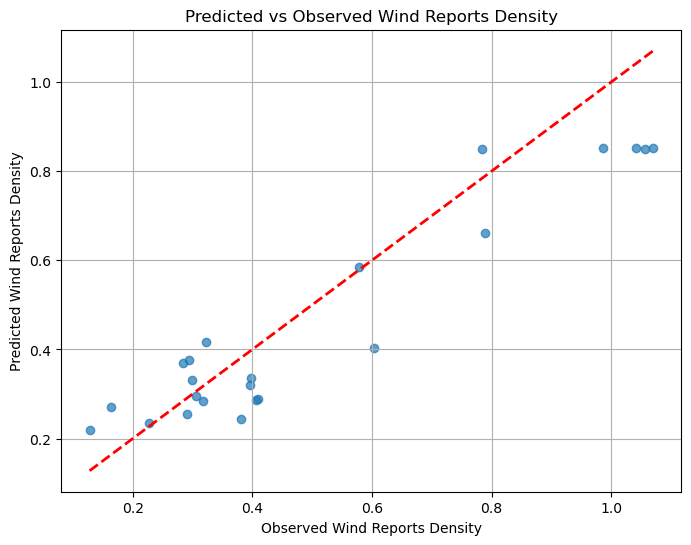

In [ ]:
# Fit the random forest regression model
# Wind first
forest_wind = RandomForestRegressor(n_estimators=100, min_samples_leaf=5, max_depth=10, random_state=42)
forest_wind.fit(X_train_wind, y_train_wind)

# Use the model to make predictions on the test set
y_pred_wind = forest_wind.predict(X_test_wind)

# Evaluate model performance
rmse = np.sqrt(root_mean_squared_error(y_test_wind, y_pred_wind))
print(f'RMSE: {rmse:.2f}')
# RMSE as a fraction of the standard deviation of the observed values
rmse_frac = rmse / np.std(y_test_wind)
print(f'RMSE as fraction of observed std dev: {rmse_frac:.2f}')
corr_coef = np.corrcoef(y_test_wind, y_pred_wind)[0, 1]
print(f'Correlation Coefficient: {corr_coef:.2f}')

# Plot predicted vs observed tornado counts
plt.figure(figsize=(8, 6))
plt.scatter(y_test_wind, y_pred_wind, alpha=0.7)
plt.plot([y_test_wind.min(), y_test_wind.max()], [y_test_wind.min(), y_test_wind.max()], 'r--', lw=2)
plt.xlabel('Observed Wind Reports Density')
plt.ylabel('Predicted Wind Reports Density')
plt.title('Predicted vs Observed Wind Reports Density')
plt.grid()
plt.show()


RMSE: 0.46
RMSE as fraction of observed std dev: 1.14
Correlation Coefficient: 0.91


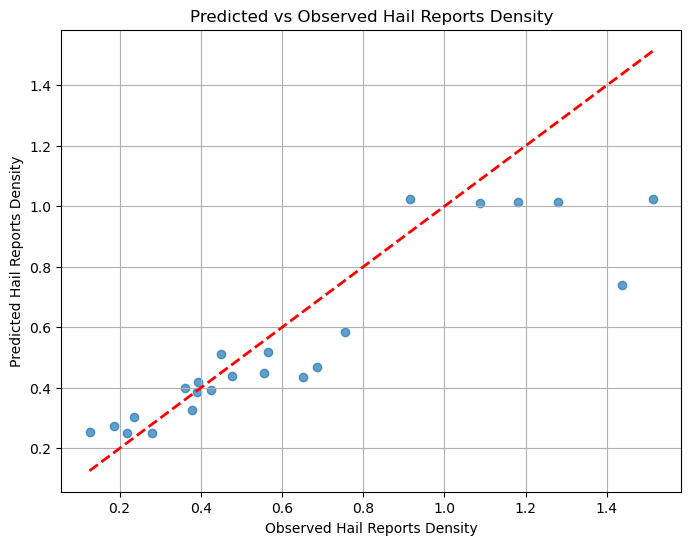

In [148]:
# Fit the random forest regression model
# Hail next

forest_hail = RandomForestRegressor(n_estimators=100, min_samples_leaf=5, max_depth=10, random_state=42)
forest_hail.fit(X_train_hail, y_train_hail)

# Use the model to make predictions on the test set
y_pred_hail = forest_hail.predict(X_test_hail)

# Evaluate model performance
rmse = np.sqrt(root_mean_squared_error(y_test_hail, y_pred_hail))
print(f'RMSE: {rmse:.2f}')
# RMSE as a fraction of the standard deviation of the observed values
rmse_frac = rmse / np.std(y_test_hail)
print(f'RMSE as fraction of observed std dev: {rmse_frac:.2f}')
corr_coef = np.corrcoef(y_test_hail, y_pred_hail)[0, 1]
print(f'Correlation Coefficient: {corr_coef:.2f}')

# Plot predicted vs observed tornado counts
plt.figure(figsize=(8, 6))
plt.scatter(y_test_hail, y_pred_hail, alpha=0.7)
plt.plot([y_test_hail.min(), y_test_hail.max()], [y_test_hail.min(), y_test_hail.max()], 'r--', lw=2)
plt.xlabel('Observed Hail Reports Density')
plt.ylabel('Predicted Hail Reports Density')
plt.title('Predicted vs Observed Hail Reports Density')
plt.grid()
plt.show()

__Observations__
<p>
Use of Log10 of population density as a feature almost imperceptivly reduced model performance. I also ran this code and included both Pop Density and Log10 Pop Density as features, and that also did not improve model performance. It doesn't seem to matter to the RF whether the population data is transformed or not (normal distribution irrelevant?).

The model is struggling with the high reports density counties - it seems to "cap" the max reports density at just over 1.0 for hail and around 0.85 for wind

### Modeling Attempt #3
Modifications:
- The target data (storm reports densities) are skewed toward the left, so trying the TransformedTargetRegressor to see if that helps with predictions

In [ ]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.compose import TransformedTargetRegressor

# X and y (example)
features = ['latitude','longitude','Pop Density ppl/mi2']  # or use Log10 pop density column
X = county_stats[features]
y = county_stats['Hail Reports Density rep/mi2']  #  skewed target

# simple preprocessor (adjust columns as needed)
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), ['latitude','longitude']),
    ('passthrough', 'passthrough', ['Pop Density ppl/mi2'])
], remainder='drop')

# baseline pipeline (no target transform)
pipe_plain = Pipeline([
    ('pre', preprocessor),
    ('rf', RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1))
])

# pipeline with TTR using log1p on target
ttr = TransformedTargetRegressor(
    regressor=RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1),
    func=np.log1p,
    inverse_func=np.expm1
)
pipe_ttr = Pipeline([
    ('pre', preprocessor),
    ('ttr', ttr)
])

# Cross-validate and compare (scores reported on original scale because TTR inverse-transforms)
scoring = ['neg_mean_squared_error', 'neg_mean_absolute_error']
cv_results_plain = cross_validate(pipe_plain, X, y, cv=5, scoring=scoring, return_train_score=False)
cv_results_ttr = cross_validate(pipe_ttr, X, y, cv=5, scoring=scoring, return_train_score=False)

# Convert neg MSE to RMSE
rmse_plain = np.sqrt(-cv_results_plain['test_neg_mean_squared_error']).mean()
mae_plain = -cv_results_plain['test_neg_mean_absolute_error'].mean()

rmse_ttr = np.sqrt(-cv_results_ttr['test_neg_mean_squared_error']).mean()
mae_ttr = -cv_results_ttr['test_neg_mean_absolute_error'].mean()

print(f'Plain RF:   RMSE={rmse_plain:.4f}, MAE={mae_plain:.4f}')
print(f'RF + TTR:   RMSE={rmse_ttr:.4f}, MAE={mae_ttr:.4f}')

Plain RF:   RMSE=0.2083, MAE=0.1487
RF + TTR:   RMSE=0.2044, MAE=0.1461


__Observations__
Small improvement in RMSE with TTR

### Modeling Attempt #4
Modifications:
- Going to add Metro Area in as a categorical feature to see if it's more helpful than lat/lon

In [157]:
county_stats.head()

FIPS code       SED location           Census location Metro Area  \
0      17013  CALHOUN, ILLINOIS  Calhoun County, Illinois  St. Louis   
1      17061   GREENE, ILLINOIS   Greene County, Missouri  St. Louis   
2      17083   JERSEY, ILLINOIS   Jersey County, Illinois  St. Louis   
3      17119  MADISON, ILLINOIS  Madison County, Missouri  St. Louis   
4      17133   MONROE, ILLINOIS   Monroe County, Missouri  St. Louis   

    latitude  longitude  Pop Density ppl/mi2  Total Hail Reports  \
0  39.169265 -90.667578            17.362082                  32   
1  39.356181 -90.390471           551.102470                  58   
2  39.085513 -90.356520            58.161843                  82   
3  38.829738 -89.904933            17.646031                 271   
4  38.278542 -90.177390            22.546009                 108   

   Total Wind Reports  Hail Reports std  Wind Reports std  Area - Land mi2  \
0                  76          0.879488          1.576483          253.829   
1                  92          1.623839          1.583821          543.144   
2                 112          1.910849          1.852534          369.555   
3                 405          6.102794          6.097975          715.515   
4                 122          2.630290          2.224278          385.301   

   Hail Reports Density rep/mi2  Wind Reports Density rep/mi2  \
0                      0.126069                      0.299414   
1                      0.106786                      0.169384   
2                      0.221888                      0.303067   
3                      0.378748                      0.566026   
4                      0.280300                      0.316636   

   Hail Reports Density std  Wind Reports Density std  \
0                  0.003465                  0.006211   
1                  0.002990                  0.002916   
2                  0.005171                  0.005013   
3                  0.008529                  0.008522   
4                  0.006827                  0.005773   

   Log10 Pop Density ppl/mi2   Pop Cat  
0                   1.239602     rural  
1                   2.741232  suburban  
2                   1.764638     rural  
3                   1.246647     rural  
4                   1.353070     rural

In [158]:
# Full disclosure: shoutout to GPT-5 for help on this code - it's getting too complicated with different options we didn't explicitly cover in class!

# Quick CV comparison: (a) base, (b) + Metro Area (one-hot), (c) + Metro Area + TTR (log10 on target)
# Assumes: no zeros in 'Pop Density ppl/mi2' or target 'Hail Reports Density rep/mi2'

import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import cross_validate

# ----- Configure column names -----
numeric_cols = ['latitude', 'longitude']
pop_col = ['Pop Density ppl/mi2']
cat_cols = ['Metro Area']
target_col = 'Hail Reports Density rep/mi2'   

# ----- Build a consistent DF for CV (drop rows missing required columns) -----
required_cols = numeric_cols + pop_col + [target_col]
df = county_stats[required_cols + cat_cols].copy()
df = df.dropna(subset=required_cols)   # ensures same rows used for all pipelines

X_base = df[numeric_cols + pop_col]
X_metro = df[numeric_cols + pop_col + cat_cols]
y = df[target_col]

# ----- Preprocessing definitions -----
numeric_transform = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('scale', StandardScaler())
])

# use np.log10 for pop (safe because there are no zeros in the target data)
pop_transform = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('log10', FunctionTransformer(np.log10, validate=False)),
    ('scale', StandardScaler())
])

# Build a OneHotEncoder that's compatible across sklearn versions
try:
    # sklearn >= ~1.2
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
except TypeError:
    # older sklearn
    ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

cat_transform = Pipeline([
    ('impute', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('onehot', ohe)
])

preprocessor_base = ColumnTransformer([
    ('num', numeric_transform, numeric_cols),
    ('pop', pop_transform, pop_col)
], remainder='drop')

preprocessor_metro = ColumnTransformer([
    ('num', numeric_transform, numeric_cols),
    ('pop', pop_transform, pop_col),
    ('metro', cat_transform, cat_cols)
], remainder='drop')

# ----- Models / Pipelines -----
# instantiate separate regressors to avoid accidental estimator sharing
rf_base = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
rf_metro = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
rf_ttr_inner = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)

pipe_base = Pipeline([
    ('pre', preprocessor_base),
    ('rf', rf_base)
])

pipe_metro = Pipeline([
    ('pre', preprocessor_metro),
    ('rf', rf_metro)
])

# TTR using log10 on target (assumes no zeros in target data)
ttr = TransformedTargetRegressor(
    regressor=rf_ttr_inner,
    func=np.log10,
    inverse_func=lambda t: 10 ** t
)

pipe_metro_ttr = Pipeline([
    ('pre', preprocessor_metro),
    ('ttr', ttr)
])

# ----- Cross-validate each pipeline -----
scoring = ['neg_mean_squared_error', 'neg_mean_absolute_error']
cv = 5

print('Running CV for base pipeline (no Metro)...')
cv_base = cross_validate(pipe_base, X_base, y, cv=cv, scoring=scoring, n_jobs=-1)

print('Running CV for pipeline with Metro Area (one-hot)...')
cv_metro = cross_validate(pipe_metro, X_metro, y, cv=cv, scoring=scoring, n_jobs=-1)

print('Running CV for pipeline with Metro Area + TTR (log10 target)...')
cv_metro_ttr = cross_validate(pipe_metro_ttr, X_metro, y, cv=cv, scoring=scoring, n_jobs=-1)

# ----- Summarize results (RMSE and MAE on original target scale) -----
def summarize(cv_res, label):
    rmse = np.sqrt(-cv_res['test_neg_mean_squared_error']).mean()
    mae = -cv_res['test_neg_mean_absolute_error'].mean()
    print(f"{label}: CV RMSE = {rmse:.6f}, CV MAE = {mae:.6f}")

print('\nSummary:')
summarize(cv_base, 'Base (no Metro)')
summarize(cv_metro, 'With Metro (one-hot)')
summarize(cv_metro_ttr, 'With Metro + TTR (log10 target)')


Running CV for base pipeline (no Metro)...
Running CV for pipeline with Metro Area (one-hot)...
Running CV for pipeline with Metro Area + TTR (log10 target)...

Summary:
Base (no Metro): CV RMSE = 0.208086, CV MAE = 0.148443
With Metro (one-hot): CV RMSE = 0.203571, CV MAE = 0.145424
With Metro + TTR (log10 target): CV RMSE = 0.196894, CV MAE = 0.141047


In [159]:
# The pipeline that included metro area and TTR with log10 on the target performed the best in CV
# Next step: hyperparameter tuning of the RandomForest inside that pipeline

# RandomizedSearchCV tuning for pipe_metro_ttr
import numpy as np
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from sklearn.model_selection import RandomizedSearchCV
import joblib   # optional, for saving the best model

# Ensure these exist from previous cell:
# - pipe_metro_ttr : Pipeline([... ('pre', preprocessor_metro), ('ttr', TransformedTargetRegressor(...)) ])
# - X_metro, y

# Parameter distributions for RandomForest (inside TTR)
param_distributions = {
    # number of trees
    'ttr__regressor__n_estimators': sp_randint(100, 1000),

    # maximum depth of the tree (None means expand until leaves are pure)
    'ttr__regressor__max_depth': sp_randint(3, 40),

    # number of features to consider at each split
    # allow floats to sample a fraction OR common strategies 'sqrt'/'log2'
    'ttr__regressor__max_features': ['sqrt', 'log2', None, 0.2, 0.5],

    # minimum samples required to split an internal node
    'ttr__regressor__min_samples_split': sp_randint(2, 20),

    # minimum samples per leaf
    'ttr__regressor__min_samples_leaf': sp_randint(1, 10),

    # whether bootstrap samples are used when building trees
    'ttr__regressor__bootstrap': [True, False]
}

# RandomizedSearchCV setup
n_iter = 30       # increase to 50-200 for more thorough search
cv = 5
random_state = 0

rs = RandomizedSearchCV(
    estimator=pipe_metro_ttr,
    param_distributions=param_distributions,
    n_iter=n_iter,
    scoring='neg_mean_squared_error',   # use appropriate scoring for your goal
    n_jobs=-1,
    cv=cv,
    verbose=2,
    random_state=random_state,
    return_train_score=False
)

# Fit the RandomizedSearch
print("Starting RandomizedSearchCV (this may take a while)...")
rs.fit(X_metro, y)

# Results summary
print("\nBest score (neg MSE):", rs.best_score_)
print("Best params:")
for k, v in rs.best_params_.items():
    print(f"  {k}: {v}")

# Compute RMSE and MAE on CV results for the best candidate (approximated from best_score_)
best_neg_mse = rs.best_score_
best_rmse = np.sqrt(-best_neg_mse)
print(f"\nApprox. CV RMSE of best candidate: {best_rmse:.6f}")

# Optionally inspect top N candidates
cv_results = rs.cv_results_
# sort by mean test score (descending, since neg MSE -> larger is better)
order = np.argsort(cv_results['mean_test_score'])[::-1]
print("\nTop 5 candidates (mean_test_score, params):")
for i in order[:5]:
    print(f"{cv_results['mean_test_score'][i]:.6f} -> {cv_results['params'][i]}")

# Save best model to disk if you want
# joblib.dump(rs.best_estimator_, filepath_out + 'best_rf_metro_ttr_randomsearch.joblib')

Starting RandomizedSearchCV (this may take a while)...
Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END ttr__regressor__bootstrap=True, ttr__regressor__max_depth=3, ttr__regressor__max_features=0.2, ttr__regressor__min_samples_leaf=4, ttr__regressor__min_samples_split=9, ttr__regressor__n_estimators=109; total time=   0.1s
[CV] END ttr__regressor__bootstrap=True, ttr__regressor__max_depth=3, ttr__regressor__max_features=0.2, ttr__regressor__min_samples_leaf=4, ttr__regressor__min_samples_split=9, ttr__regressor__n_estimators=109; total time=   0.1s
[CV] END ttr__regressor__bootstrap=True, ttr__regressor__max_depth=3, ttr__regressor__max_features=0.2, ttr__regressor__min_samples_leaf=4, ttr__regressor__min_samples_split=9, ttr__regressor__n_estimators=109; total time=   0.1s
[CV] END ttr__regressor__bootstrap=True, ttr__regressor__max_depth=3, ttr__regressor__max_features=0.2, ttr__regressor__min_samples_leaf=4, ttr__regressor__min_samples_split=9, ttr__regressor__

__Observations__
- Tuning the hyperparameters appears to have made the model performance _worse_
    - CV RMSE of the pipeline that left hyperparameters to their defaul and included Metro Are + TTR (log10 target): 
        - CV RMSE = 0.196894, CV MAE = 0.141047
    - Approx. CV RMSE of best candidate using RandomizedSearchCV: 
        - CV RMSE = 0.208976

### Modeling Attempt #5
<p>
Modifications: Using the best model so far (the pipeline that relied on default hyperparameters and included one-hot encoded Metro Area + TTR of the target), and training that model on the full dataset.


In [161]:
county_stats.head()

FIPS code       SED location           Census location Metro Area  \
0      17013  CALHOUN, ILLINOIS  Calhoun County, Illinois  St. Louis   
1      17061   GREENE, ILLINOIS   Greene County, Missouri  St. Louis   
2      17083   JERSEY, ILLINOIS   Jersey County, Illinois  St. Louis   
3      17119  MADISON, ILLINOIS  Madison County, Missouri  St. Louis   
4      17133   MONROE, ILLINOIS   Monroe County, Missouri  St. Louis   

    latitude  longitude  Pop Density ppl/mi2  Total Hail Reports  \
0  39.169265 -90.667578            17.362082                  32   
1  39.356181 -90.390471           551.102470                  58   
2  39.085513 -90.356520            58.161843                  82   
3  38.829738 -89.904933            17.646031                 271   
4  38.278542 -90.177390            22.546009                 108   

   Total Wind Reports  Hail Reports std  Wind Reports std  Area - Land mi2  \
0                  76          0.879488          1.576483          253.829   
1                  92          1.623839          1.583821          543.144   
2                 112          1.910849          1.852534          369.555   
3                 405          6.102794          6.097975          715.515   
4                 122          2.630290          2.224278          385.301   

   Hail Reports Density rep/mi2  Wind Reports Density rep/mi2  \
0                      0.126069                      0.299414   
1                      0.106786                      0.169384   
2                      0.221888                      0.303067   
3                      0.378748                      0.566026   
4                      0.280300                      0.316636   

   Hail Reports Density std  Wind Reports Density std  \
0                  0.003465                  0.006211   
1                  0.002990                  0.002916   
2                  0.005171                  0.005013   
3                  0.008529                  0.008522   
4                  0.006827                  0.005773   

   Log10 Pop Density ppl/mi2   Pop Cat  
0                   1.239602     rural  
1                   2.741232  suburban  
2                   1.764638     rural  
3                   1.246647     rural  
4                   1.353070     rural

In [163]:
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import cross_validate

# ----- Configure column names -----
numeric_cols = ['latitude', 'longitude']
pop_col = ['Pop Density ppl/mi2']
cat_cols = ['Metro Area']
target_col = 'Hail Reports Density rep/mi2'  # change this to 'Wind Reports Density rep/mi2' as needed  

# ----- Build a consistent DF for CV (drop rows missing required columns) -----
required_cols = numeric_cols + pop_col + [target_col]
df = county_stats[required_cols + cat_cols].copy()
df = df.dropna(subset=required_cols)   # ensures same rows used for all pipelines

X = df[numeric_cols + pop_col + cat_cols]
y = df[target_col]

# ----- Preprocessing definitions -----
numeric_transform = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('scale', StandardScaler())
])

# use np.log10 for pop (safe because there are no zeros in the target data)
pop_transform = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('log10', FunctionTransformer(np.log10, validate=False)),
    ('scale', StandardScaler())
])

# Build a OneHotEncoder that's compatible across sklearn versions
try:
    # sklearn >= ~1.2
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
except TypeError:
    # older sklearn
    ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

cat_transform = Pipeline([
    ('impute', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('onehot', ohe)
])

preprocessor_metro = ColumnTransformer([
    ('num', numeric_transform, numeric_cols),
    ('pop', pop_transform, pop_col),
    ('metro', cat_transform, cat_cols)
], remainder='drop')

# ----- Models / Pipelines -----
# instantiate separate regressors to avoid accidental estimator sharing
rf_ttr_inner = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)

# TTR using log10 on target (assumes no zeros in target data)
ttr = TransformedTargetRegressor(
    regressor=rf_ttr_inner,
    func=np.log10,
    inverse_func=lambda t: 10 ** t
)

pipe_metro_ttr = Pipeline([
    ('pre', preprocessor_metro),
    ('ttr', ttr)
])

In [164]:
# Separate features and targets
features = county_stats[['Metro Area','latitude','longitude','Pop Density ppl/mi2']]
features_wind = county_stats['Wind Reports Density rep/mi2']
features_hail = county_stats['Hail Reports Density rep/mi2']

# Set variables for modeling
X = features
y_wind = features_wind
y_hail = features_hail

X.shape, y_wind.shape, y_hail.shape

# Split the training and testing data
# Reserve 25% of the data for testing

# Wind
X_train_wind, X_test_wind, y_train_wind, y_test_wind = train_test_split(X, y_wind, test_size=0.25, random_state=42)
print('Wind train size:', X_train_wind.shape, 'Wind test size:', X_test_wind.shape)

# Hail
X_train_hail, X_test_hail, y_train_hail, y_test_hail = train_test_split(X, y_hail, test_size=0.25, random_state=42)
print('Hail train size:', X_train_hail.shape, 'Hail test size:', X_test_hail.shape)

Wind train size: (68, 4) Wind test size: (23, 4)
Hail train size: (68, 4) Hail test size: (23, 4)


RMSE: 0.22
RMSE as fraction of observed std dev: 0.73
Correlation Coefficient: 0.99


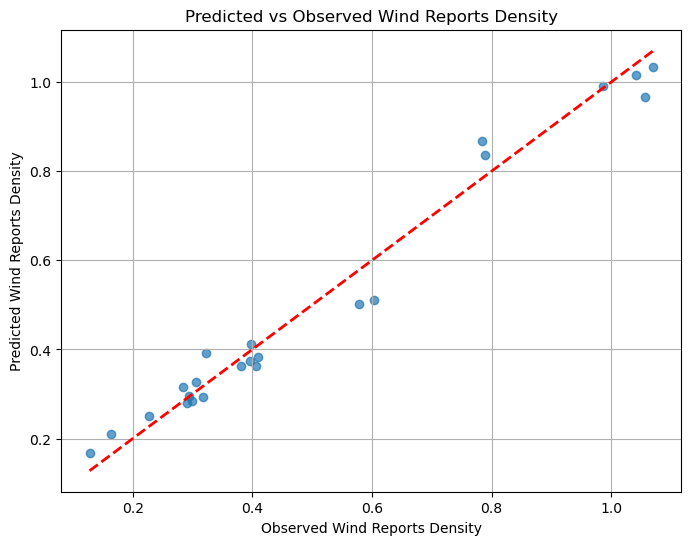

In [ ]:
# Metro + TTR is the best pipeline
# Train the best pipeline on the full dataset

# Wind first
best_pipe = pipe_metro_ttr
best_pipe.fit(X_test_wind, y_test_wind)

# Use the model to make predictions on the test set
y_pred_wind = best_pipe.predict(X_test_wind)

# Evaluate model performance
rmse = np.sqrt(root_mean_squared_error(y_test_wind, y_pred_wind))
print(f'RMSE: {rmse:.2f}')
# RMSE as a fraction of the standard deviation of the observed values
rmse_frac = rmse / np.std(y_test_wind)
print(f'RMSE as fraction of observed std dev: {rmse_frac:.2f}')
corr_coef = np.corrcoef(y_test_wind, y_pred_wind)[0, 1]
print(f'Correlation Coefficient: {corr_coef:.2f}')

# Plot predicted vs observed tornado counts
plt.figure(figsize=(8, 6))
plt.scatter(y_test_wind, y_pred_wind, alpha=0.7)
plt.plot([y_test_wind.min(), y_test_wind.max()], [y_test_wind.min(), y_test_wind.max()], 'r--', lw=2)
plt.xlabel('Observed Wind Reports Density')
plt.ylabel('Predicted Wind Reports Density')
plt.title('Predicted vs Observed Wind Reports Density')
plt.grid()
plt.show()

# Whoa, that's a lot better! Dang, I'm surprised.

RMSE: 0.28
RMSE as fraction of observed std dev: 0.69
Correlation Coefficient: 0.98


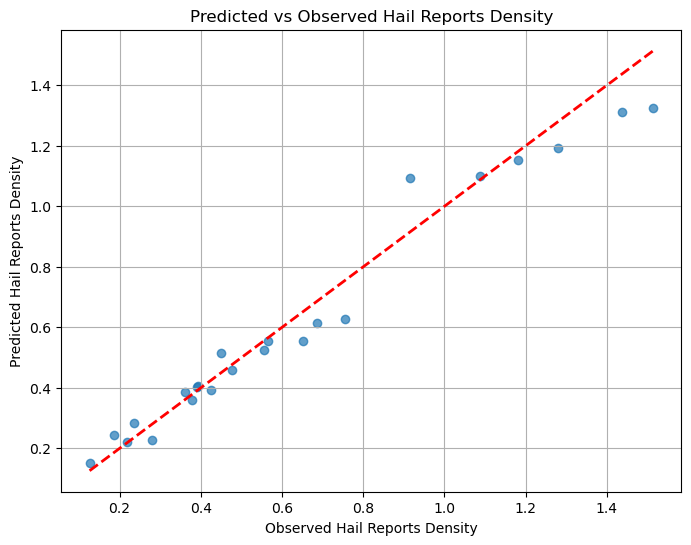

In [169]:
# Hail next
best_pipe = pipe_metro_ttr
best_pipe.fit(X_test_hail, y_test_hail)

# Use the model to make predictions on the test set
y_pred_hail = best_pipe.predict(X_test_hail)

# Evaluate model performance
rmse = np.sqrt(root_mean_squared_error(y_test_hail, y_pred_hail))
print(f'RMSE: {rmse:.2f}')
# RMSE as a fraction of the standard deviation of the observed values
rmse_frac = rmse / np.std(y_test_hail)
print(f'RMSE as fraction of observed std dev: {rmse_frac:.2f}')
corr_coef = np.corrcoef(y_test_hail, y_pred_hail)[0, 1]
print(f'Correlation Coefficient: {corr_coef:.2f}')

# Plot predicted vs observed tornado counts
plt.figure(figsize=(8, 6))
plt.scatter(y_test_hail, y_pred_hail, alpha=0.7)
plt.plot([y_test_hail.min(), y_test_hail.max()], [y_test_hail.min(), y_test_hail.max()], 'r--', lw=2)
plt.xlabel('Observed Hail Reports Density')
plt.ylabel('Predicted Hail Reports Density')
plt.title('Predicted vs Observed Hail Reports Density')
plt.grid()
plt.show()

__Observations:__
<p>
Including the metro area and transforming the target via log10 really improved the RMSE and correlation coefficient, especially at the high end (i.e. for urban counties with high population densities and high storm reports densities!

- "Raw" RF Regressor performance:
    - Wind:
        - RMSE: 0.34
        - RMSE as fraction of observed std dev: 1.15
        - Correlation Coefficient: 0.95
    - Hail:
        - RMSE: 0.46
        - RMSE as fraction of observed std dev: 1.14
        - Correlation Coefficient: 0.91

- Optimized RF Regressor performance:
    - Wind:
        - RMSE: 0.22
        - RMSE as fraction of observed std dev: 0.73
        - Correlation Coefficient: 0.99
    - Hail:
        - RMSE: 0.28
        - RMSE as fraction of observed std dev: 0.69
        - Correlation Coefficient: 0.98


## Explainability 
Determining which features are most important in this optimized RF regressor.

Note: the below code is working with the model trained on _hail_ data specifically.

### Random Forest Feature Importance (MDI)

Top 20 feature importances:
Pop Density ppl/mi2       0.640743
longitude                 0.190924
latitude                  0.123603
Metro Area_St. Louis      0.016611
Metro Area_OKC            0.012627
Metro Area_DFW            0.006123
Metro Area_Tulsa          0.005901
Metro Area_Kansas City    0.003468
dtype: float64


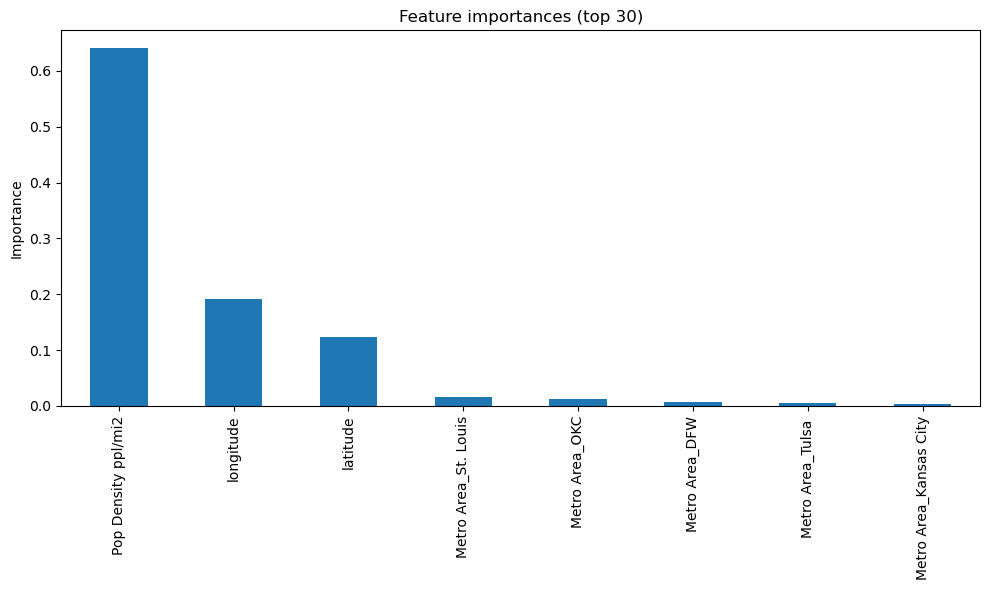

In [171]:
# I originally tried using the simple model.feature_importances_ attribute to look at feature importance, but that doesn't work with 
# pipelines that include preprocessing steps and target transformers. 
# Instead, I apparently we need to extract the trained RandomForestRegressor from within the pipeline after fitting, 
# and then access its feature_importances_ attribute. 
# Another shoutout to GPT-5 for helping with this one.

# Evaluate feature importances for a fitted pipeline (works with pipe_metro_ttr or RandomizedSearchCV)

def get_feature_names_from_column_transformer(ct):
    """
    Return feature names after a ColumnTransformer.
    Works with transformers that are Pipelines and with transformers that
    implement get_feature_names_out (e.g., OneHotEncoder).
    """
    feature_names = []

    # ct.transformers_ is available after fitting
    for name, trans, cols in ct.transformers_:
        if trans == 'drop' or name == 'remainder' and trans == 'drop':
            continue
        if trans == 'passthrough':
            # passthrough just keeps the input column names
            if isinstance(cols, (list, tuple, np.ndarray)):
                feature_names.extend(list(cols))
            else:
                # slice handling — best-effort fallback
                feature_names.append(str(cols))
            continue

        # If a pipeline was used, get the last transformer
        transformer = trans
        if hasattr(trans, 'named_steps'):
            # get the last step in pipeline
            last_step_name = list(trans.named_steps.keys())[-1]
            transformer = trans.named_steps[last_step_name]

        # Try to use get_feature_names_out (scikit-learn >= 1.0)
        if hasattr(transformer, 'get_feature_names_out'):
            try:
                names = list(transformer.get_feature_names_out(cols))
            except Exception:
                # some transformers expect different input; fall back
                names = [f"{name}__{c}" for c in (cols if isinstance(cols, (list, tuple, np.ndarray)) else [cols])]
        else:
            # Fallback: numeric transformers (StandardScaler, etc.) keep original names
            names = list(cols) if isinstance(cols, (list, tuple, np.ndarray)) else [cols]

        feature_names.extend(names)

    return feature_names

# --- Select the pipeline object that is fitted ---
# if you used RandomizedSearchCV and have 'rs', use rs.best_estimator_
est = None
if 'rs' in globals() and hasattr(rs, 'best_estimator_'):
    est = rs.best_estimator_
elif 'best_pipe' in globals():
    est = best_pipe
else:
    raise RuntimeError("No fitted pipeline object found in `rs` or `best_pipe` variables.")

# Ensure the estimator is fitted
# If TransformedTargetRegressor is the final step, it has attribute regressor_ after fitting.
# Preprocessor assumed to be named 'pre' in the pipeline (adjust if you used a different name).
preprocessor = est.named_steps.get('pre')
if preprocessor is None:
    raise RuntimeError("Pipeline does not contain a 'pre' named step. Adjust the step name in the script.")

# get feature names (preprocessor must be fitted)
feature_names = get_feature_names_from_column_transformer(preprocessor)

# get the fitted regressor inside TTR or final step
if 'ttr' in est.named_steps:
    # TransformedTargetRegressor wraps a regressor; after fitting the inner regressor is in .regressor_
    ttr = est.named_steps['ttr']
    reg = getattr(ttr, 'regressor_', None)
    if reg is None:
        raise RuntimeError("TransformedTargetRegressor is not fitted yet. Fit the pipeline first.")
else:
    # final estimator is directly available as the last step
    final_step_name = est.steps[-1][0]
    reg = est.named_steps[final_step_name]
    if not hasattr(reg, 'feature_importances_'):
        raise RuntimeError("Final estimator has no `feature_importances_` attribute.")

# Safety check: lengths match
fi = getattr(reg, 'feature_importances_', None)
if fi is None:
    raise RuntimeError("Regressor does not expose feature_importances_.")
if len(fi) != len(feature_names):
    print("Warning: length mismatch between importances and feature names.")
    print("len(importances) =", len(fi), ", len(feature_names) =", len(feature_names))
    # Show n_features_in_ for debugging
    if hasattr(reg, 'n_features_in_'):
        print("reg.n_features_in_ =", reg.n_features_in_)
    # attempt to proceed using min length
    n = min(len(fi), len(feature_names))
    fi = fi[:n]
    feature_names = feature_names[:n]

# Map to pandas Series and sort
importances = pd.Series(fi, index=feature_names).sort_values(ascending=False)

# Print top features
print("Top 20 feature importances:")
print(importances.head(20))

# Plot
plt.figure(figsize=(10,6))
importances.head(30).plot(kind='bar')
plt.title('Feature importances (top 30)')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()



__Observations:__
<p>
As expected from EDA, population density is the most important feature. The model is also using lon and lat coordinates, which makes intuitive sense - lat/lon describe the region-specific characteristics of the svr wx climatology.

### Permutation Importance

Baseline (train) RMSE: 0.185438
Computing permutation importance (n_repeats=30)... this may take a while.

Top features by permutation importance (MSE increase):
               feature  importance_mean_mse_increase  importance_std  \
0  Pop Density ppl/mi2                      0.157909        0.020156   
1            longitude                      0.012565        0.003640   
2           Metro Area                      0.003869        0.001137   
3             latitude                      0.003447        0.000820   

   importance_mean_rmse_increase  
0                       0.253078  
1                       0.031247  
2                       0.010153  
3                       0.009072  


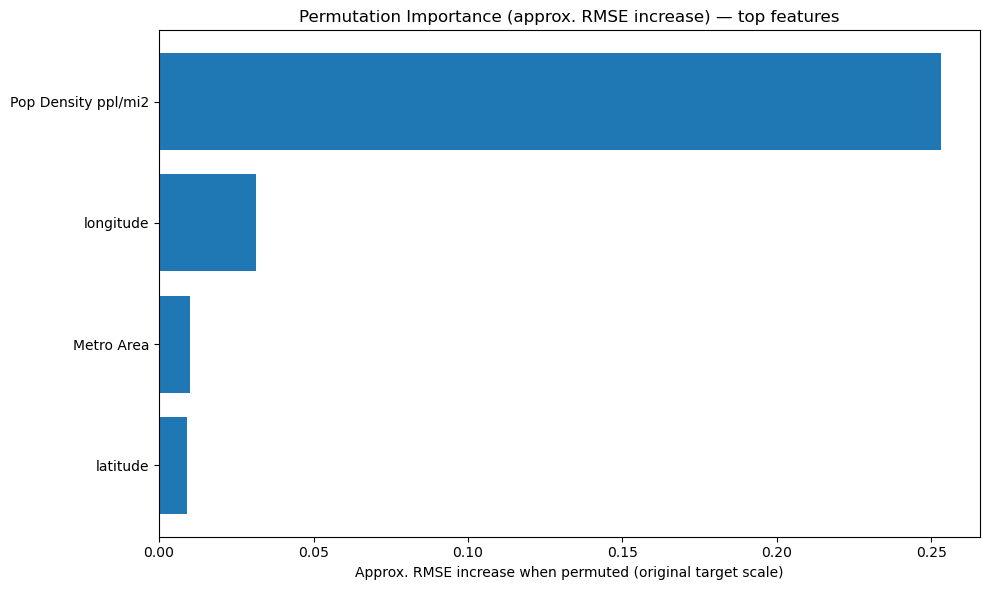

In [172]:
# Permutation importance for a fitted pipeline (best_pipe / pipe_metro_ttr)
# - Uses the whole pipeline (preprocessor + TTR) so permuting original input columns
#   measures the effect of each original feature on final predictions (original target scale).
# - Assumes X (DataFrame with original input columns) and y (Series) are available.
# - If estimator is not fitted, this will fit it (warns first).
#
# Notes:
# - Uses scoring='neg_mean_squared_error' (so importances are increases in MSE when the feature is permuted).
# - We also compute the approximate RMSE increase for interpretability.
# - Adjust `n_repeats` for more stable estimates (30+ recommended), but it takes longer.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
import warnings

# --- Select estimator: prefer `best_pipe` if present, then RandomizedSearchCV `rs.best_estimator_`,
#     otherwise try `pipe_metro_ttr`. ---
if 'best_pipe' in globals():
    estimator = best_pipe
elif 'rs' in globals() and hasattr(rs, 'best_estimator_'):
    estimator = rs.best_estimator_
elif 'pipe_metro_ttr' in globals():
    estimator = pipe_metro_ttr
else:
    raise RuntimeError("No pipeline found: define `best_pipe`, `rs.best_estimator_`, or `pipe_metro_ttr` first.")

# --- Ensure X and y exist (use variables created earlier). If not found, try to recreate them from county_stats. ---
if 'X' in globals() and 'y' in globals():
    X_input = X
    y_input = y
else:
    # attempt to build from your earlier column lists (numeric_cols, pop_col, cat_cols, target_col)
    try:
        X_input = county_stats[numeric_cols + pop_col + cat_cols].copy()
        y_input = county_stats[target_col].copy()
        # drop rows missing in required cols to keep a clean set
        nonnull_mask = X_input.notna().all(axis=1) & y_input.notna()
        X_input = X_input.loc[nonnull_mask]
        y_input = y_input.loc[nonnull_mask]
        print("Recreated X and y from `county_stats`.")
    except Exception as e:
        raise RuntimeError("Could not find `X`/`y` and failed to recreate from `county_stats`: " + str(e))

# Quick checks
if not isinstance(X_input, pd.DataFrame):
    # permutation_importance works with arrays, but column names make output clearer
    X_df = pd.DataFrame(X_input, columns=(numeric_cols + pop_col + cat_cols))
else:
    X_df = X_input.copy()

# Ensure estimator is fitted. Try a predict; if fails, fit on (X, y) after warning.
fitted = True
try:
    estimator.predict(X_df.iloc[:5])
except Exception:
    fitted = False

if not fitted:
    warnings.warn("Estimator does not appear fitted. Fitting estimator on (X, y) before computing permutation importance.")
    estimator.fit(X_df, y_input)

# Baseline MSE and RMSE on provided data (not CV)
y_pred = estimator.predict(X_df)
baseline_mse = mean_squared_error(y_input, y_pred)
baseline_rmse = np.sqrt(baseline_mse)
print(f"Baseline (train) RMSE: {baseline_rmse:.6f}")

# Compute permutation importance
n_repeats = 30
random_state = 0

print(f"Computing permutation importance (n_repeats={n_repeats})... this may take a while.")
perm = permutation_importance(
    estimator,
    X_df,
    y_input,
    n_repeats=n_repeats,
    random_state=random_state,
    scoring='neg_mean_squared_error',  # importance = increase in MSE (because neg MSE decreases)
    n_jobs=-1
)

# Build results DataFrame
feat_names = list(X_df.columns)
results = pd.DataFrame({
    'feature': feat_names,
    'importance_mean_mse_increase': perm.importances_mean,   # positive = permuting increased MSE
    'importance_std': perm.importances_std
})
results['importance_mean_rmse_increase'] = np.sqrt(np.maximum(0, baseline_mse + results['importance_mean_mse_increase'])) - baseline_rmse

results = results.sort_values('importance_mean_mse_increase', ascending=False).reset_index(drop=True)

# Display top features
pd.set_option('display.precision', 6)
print("\nTop features by permutation importance (MSE increase):")
print(results.head(20))

# Plot top 20
top_n = min(20, len(results))
plt.figure(figsize=(10,6))
plt.barh(results['feature'].head(top_n)[::-1], results['importance_mean_rmse_increase'].head(top_n)[::-1])
plt.xlabel('Approx. RMSE increase when permuted (original target scale)')
plt.title('Permutation Importance (approx. RMSE increase) — top features')
plt.tight_layout()
plt.show()

# Optional: save results to CSV
# results.to_csv(filepath_out + 'permutation_importance_pipe_metro_ttr.csv', index=False)

__Observations:__
<p>
As expected, population density is the most important predictor - hooray for consistency among evaluation metrics!

### SHAP Summary Plot showing feature importance and feature effects


In [175]:
y.head()

0    0.126069
1    0.106786
2    0.221888
3    0.378748
4    0.280300
Name: Hail Reports Density rep/mi2, dtype: float64

  0%|          | 0/91 [00:00<?, ?it/s]

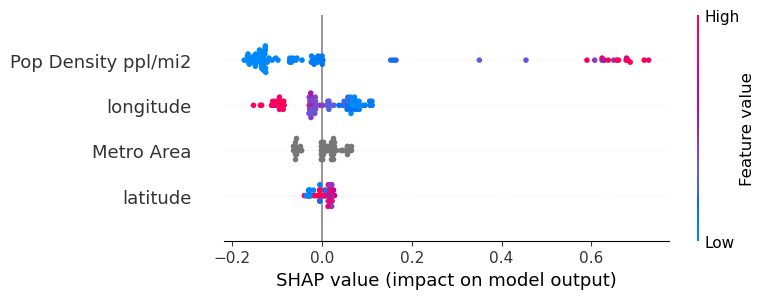

In [173]:
# Model-agnostic option: KernelExplainer on the pipeline.predict wrapper
# WARNING: much slower than TreeExplainer. Use a subset for speed (not a problem here because there's so little data).
import shap

# 1) ensure pipeline is fitted and X_df is a DataFrame of original input columns
X_df = X.copy() if isinstance(X, pd.DataFrame) else pd.DataFrame(X, columns=(numeric_cols + pop_col + cat_cols))

# 2) prediction wrapper: takes DataFrame/array -> predictions on original scale
def pipeline_predict(X_in):
    # shap may pass numpy arrays; ensure DataFrame with same columns
    if not isinstance(X_in, pd.DataFrame):
        X_in = pd.DataFrame(X_in, columns=X_df.columns)
    return pipe_metro_ttr.predict(X_in)

# 3) choose a small background sample (e.g., 50 rows) to approximate expectation
background = shap.sample(X_df, nsamples=50, random_state=0)  # choose stable small background

# 4) subset to explain (for speed also)
X_explain = shap.sample(X_df, nsamples=200, random_state=1)   # change as needed

# 5) KernelExplainer (model-agnostic)
explainer = shap.KernelExplainer(pipeline_predict, background)
shap_values = explainer.shap_values(X_explain, n_samples=200)  # increase n_samples for stability

# 6) summary plot (uses original feature names)
shap.summary_plot(shap_values, X_explain, feature_names=X_df.columns, show=True)

__Observations:__
<p>

- We saw this in the scatter plots, but it's nice to see it captured in the model: population density is most helpful as a predictor for high population-density counties. There's more variability in the low population-density counties.
- And for low population-density counties, longitude becomes a more important discriminator for low population-density counties. In low pop-density counties, it's more about location and climatology.
- Latitude is surprisingly messy and not particularly helpful. 

# CONCLUSIONS
1) Due to population bias, the density of storm reports can be predicted based on location and population density
2) This in and of itself isn't super helpful operationally, but it does suggest that using WWAs instead of lat/lon _could_ be operationally useful. But ingesting WWA density per county + population density per county, I suspect we could get reasonable estimates for storm reports density, which, in turn, could be used to estimate the "missing" number of storm reports (i.e. the unreported amount of severe weather).
    - Of course, you could also just skip the storm reports modeling and use WWA density as a proxy for severe wx risk, too...

# NEXT STEPS

- Add NWS severe thunderstorm (SV) and tornado (TO) warnings into the model. The warnings will serve as a climate proxy since they (ideally) aren't issued based on the anticipated impacted population (i.e. a severe thunderstorm warning is issued even if that storm is over an undeveloped grassland). My goal is that incorporating the WWAs will allow this analysis to be expanded beyond just this 5-metro area study. <p>
- Incorporate more frequent census data. It's a tedious manual process to gather and process the county-level data, but probably wise to average across 2020, 2000, 1980, and 1960.

### WWA Considerations
- This gets tricky. 
    - WWA data are available from 1986 - 2024 from Iowa Environmental Mesonet (IEM). I cannot find a source of NWS warnings going back to 1955 in any sort of reasonably-parseable format.
    - The NWS has not had a consistent methodology for issuing severe weather warnings throughout the study period. 
        - Before 2002: only county-based warnings available through IEM, but some indications that certain WFOs were experimenting with SBW even earlier (see some SBW from NWS TSA as early as 1998)
        - 2002 - Sept 30, 2007: WFOs began experimenting with polygon (storm-based) warnings, often issuing them alongside the traditional county-based warning (such that there could be two warnings for the same storm, one SBW and one county-based warning). Some WFO's started doing this early, some started later - it's a hodgepodge.
        -  After Oct 1, 2007: The NWS officially switched to SBW. _However_ some WFOs were continuing to issue county-based warnings (in addition to SBW) all the way through 2024 (e.g. TSA on 11/04/2024). This again presents the problem of having two warnings for the same storm, and thus "double-counting" that storm unless precautions are taken.

__Data Source__ 
- Source of WWA data: IEM https://mesonet.agron.iastate.edu/info/datasets/vtec.html 
    - "_How do polygon warnings exist in the IEM archive prior to being official?_ The NWS offices started experimenting with polygons beginning in 2002. These polygons were included with the warnings, but sometimes were not geographically valid and/or leaked well outside of a local office's CWA bounds. On 1 October 2007, these polygons became the official warning for some VTEC types. In general, the IEM's data ingestor attempts to save these polygons whenever found."

__Time Period__ 
- WWA data available from IEM for the period (1986 - 2024): this is more than the standard 30-year climatology window, so hopefully the vagaries of weather will be averaged out, and it'll be 'safe' to compare this window to the 1955 - 2024 window I use for the SED storm reports data. But to make the analysis more robust, I'd likely need to re-run my scripts and compare apples-to-apples (SED to WWAs) using the same time period of 1986 - 2024.
 
 __Options for Addressing Changes to Warning Methodologies__
- Storm-based warning polygons are available starting in 2002 (per availability on IEM), but were not fully rolled-out across the WFOs until Oct 1, 2007 (https://www.weather.gov/media/crp/STWJFall07.pdf) 
    - _However_ I still find countywide tornado warnings through 2024 (e.g. 11/04/2024 in NWS TWA). For some storms, there are only polygon warnings while for other storms, there are both polygon warnings _and_ county-based warnings _even within the same event_. This leads to a _high risk of double-counting_ if I use _both_ SBW and county-based warnings during the same period. Therefore, I think the best approach is to split it up.
    - Before Oct 1, 2007: Use only county-based warnings for all events prior to 2007 - the year when SBW were rolled out to all WFOs - even if there are SBW polygons for some early-adopter WFOs
        - Need to ensure that prior to Oct 1, 2007, all included WFOs were also consistently issuing county-based warnings, not just SBW. If some WFOs had already switched exclusively to SBW, then I'd have to convert the SBW to county-based warnings (i.e. if a polygon included any part of a county, that county would be "activated")
    - After Oct 1, 2007: use only SBW polygons for all events after 2007, even if there are some county-based warnings during those more recent years (discard those county-based warnings)

- look at these periods _separately_
    - 1986 - Sept 30, 2007: county-based warnings (use 2000 census data to be consistent)
    - Oct 1, 2007 - 2024: polygon-based warnings (use 2020 census data)
    - __which warning methodology is a better predictor of storm reports frequency?__ 

__Brainstorming Options and Alternatives__
- alternative: 
    1) convert polygons to county-based warnings for 2007 onward, thus making them comparable to the pre-2007 county-based warnings (if a polygon covers any part of a county, it counts as a county-warning). This would allow me to use the entire record of 1986 - 2024 by converting oranges (polygon warnings) into apples (county warnings). 
        - In order to avoid double-counting, I'd need to exclude issued county-based warnings during the 2007 -> period
        - In order to avoid double-counting, I'd need to include logic for a "lockout period" - only one SBW can "activate" a county per every hour? Or perhaps combine polygons for every 6 hour period - doing so would eliminate the "overlap" and just show the total area. Then that total area could be clipped by county.
    2) use polygon-based warnings from 2007 onward, and for each warning, calculate the % of the county covered by the warning. Then add up all those percentages to get a warning "impact score". 2007 - 2024 is far too short for a proper climatology and far shorter than the 1955 - 2024 SED period. But it could be interesting to compare with the county-based methodology. I'd need to re-run the SED scripts to just get SED reports from 2007 - 2024 to compare with the polygon-based WWAs
        - In order to avoid double-counting, I'd need to exclude overlapping polygons for the same storm event (e.g. when warnings are continued, they include some overlap of old and new warning). The easiest logic for this is probably to subtract overlapping polygon areas if the issuance is within ~ 2 hours 
- If I stick to the more modern period, I could also make use of the WWA hail and wind tags to distinguish between hail and wind storm events (hail storms usually also include the svr wind tag, but many wind storms are tagged for svr wind but not svr hail). But this was only deployed nationwide in 2016, which doesn't leave much data to analyze (2016 - 2024 = 8 yrs)

- Initial attempt: use entire available period of record (1986 - 2024), and convert polygon-based warnings to county-based for 2007 onward. 

### Included NWS WFOs by Metro Area
- DFW: Fort Worth (FWD)
- OKC: Norman (OUN) & Tulsa (TSA)
- Tulsa: Tulsa (TSA)
- Kansas City: Topeka (TOP) & Pleasant Hill (EAX)
- St. Louis: St. Louis (LSX)

### Example of SBW and County-Based Warnings Still Being Issued
What's the rhyme or reason for this??

- Confusing!! NWS WFO TSA continues to issue some C TO warnings even into 2024. But they're not doing it consistently. Even for the _same event_, some SBWs seems to coincide with a county-based warning, while other SBWs do not have an accompanying county-based warning. 
    - This could be a result of how IEM is parsing the data
    - But it could also be reflective of actual behavior by NWS TSA issueing county-based warnings for some but not all tornadic storms

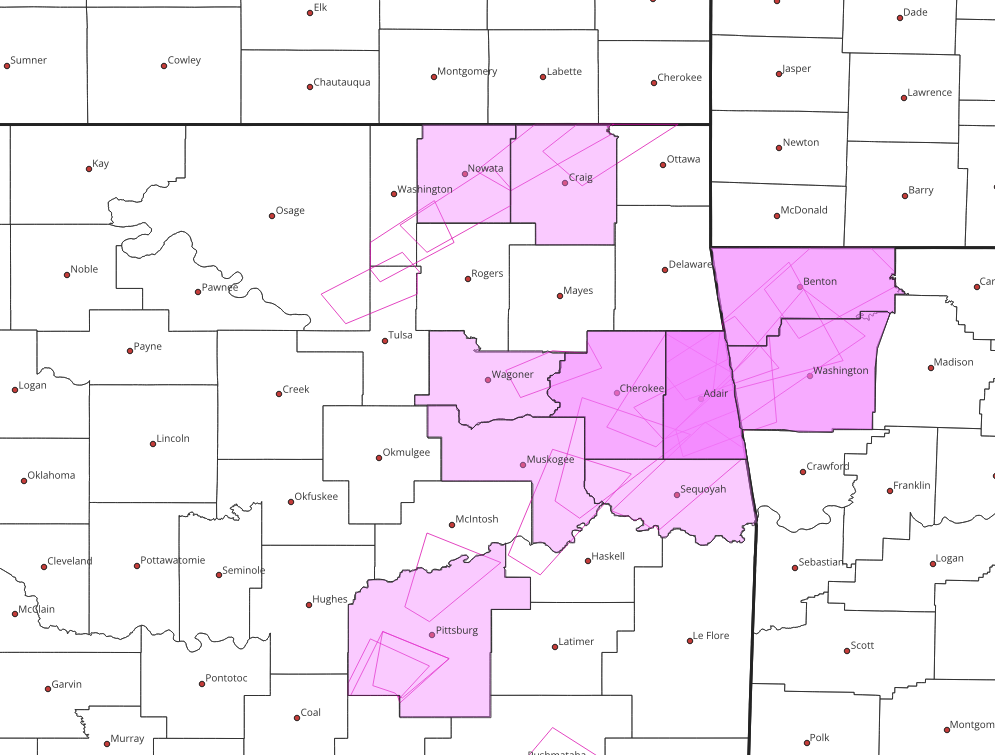
- Figure: Tornado SBW polygons (outlined) and tornado county-based warnings (shaded) issued by NWS TSA on 11/04/2024, per IEM WWA data.



## To Do
1) Download WWA shapefiles
    - Jan 1, 1986 - Sept 30, 2007: filter to only C for SV and TO
    - Oct 1, 2007 - Dec 31, 2024: filter to only P for SV and TO
2) Decide on ML model to try first
3) Run that model on the whole 1955 - 2024 dataset for wind
    - target: total number of wind reports
    - features:
        - lat
        - lon
        - population density
4) Run that model on the whole 1955 - 2024 dataset for hail
    - target: total number of wind reports
    - features:
        - lat
        - lon
        - population density
5) Do the results suggest these features can model the target? I.e. can lat/lon + pop density provide a decent estimate of total number of reports?
6) Re-run the SED analysis script for 01/01/1986 - 09/30/2007
7) Re-run the SED analysis script for 10/01/2007 - 12/31/2024
8) Analyze WWAs for 01/01/1986 - 09/30/2007 (county-based warnings only)
    - use GIS to calculate number of times during the period that the county was under a svr tstorm or torn warning 
    - multiply that by the county land area
    - get "total warned area" for the period
9) Run the ML model for 01/01/1986 - 09/30/2007
    - target: total number of wind reports
    - features:
        - lat
        - lon
        - population density
        - WWA total warned area
10) Perform feature importance analysis - with WWAs included, is lat/lon necessary? Hypothesize that it's necessary when WWA data isn't available because it serves as a substitute for svr climo
11) Run the model again with only pop density and WWA total warned area as features
12) Perform steps #9 - 11 again but for hail reports
13) Analyze WWAs for 10/01/2007 - 12/31/2024 (polygon (SBW) warnings only)
    - use GIS to calculate the total warned area for the period
        - combine polygons every 6 hours: will eliminate overlapping component of warnings during the same event (or mostly - could get overlap at the temporal margins)
        - clip the polygons by the county boundaries to calculate the fraction of the county covered by each combined polygon
        - multiply that fraction by the county area to get the total warned area
14) Perform steps #9 - 12 again for the period 10/01/2007 - 12/31/2024
15) If there's time, play with converting the polygon warnings of 2007 - 2024 to county-based warnings (i.e. if a polygon includes a county, it "activates" that county) in order to run the model over the entire 1986 - 2024 period using county-based warnings.
